# Training of an Expected Assists Model from Opta Event Data

Notebook to train an Expected Assists (xA) model from Opta data by Stats Perform Tracking data using pandas and scikit-learn.
### Credit to Edd Webster
https://github.com/eddwebster/football_analytics/blob/master/notebooks/5_data_analysis_and_projects/xg_modeling/opta_dataset/Training%20of%20an%20Expected%20Goals%20Model%20from%20Opta%20Event%20Data.ipynb

Notebook first written: 20/01/2022
Notebook last updated: 26/01/2022

# Introduction

This notebook creates a basic Expected Assists model in Python using a sample data of just under 11,000 passes of Opta data Event data by Stats Perform, scraped from WhoScored!.

This notebook uses pandas DataFrames, matplotlib for visualisations, and scikit-learn for Machine Learning, as well as a few other libraries.

For more information about this notebook and the author, Edd Webster is available through all the following channels:

- eddwebster.com;
- edd.j.webster@gmail.com;
- @eddwebster;
- linkedin.com/in/eddwebster;
- github/eddwebster; and
- public.tableau.com/profile/edd.webster.

A static version of this notebook can be found here. This notebook has an accompanying watford GitHub repository and for my full repository of football analysis, see my football_analysis GitHub repository.

# Notebook Contents

1. [Notebook Dependencies](#section1)

2. [Project Brief](#section2)

3. [Data Sources](#section3)

    1.[Data Dictionary](#section3.1)

    2.[Creating the DataFrame](#section3.2)

    3.[Initial Data Handling](#section3.3)
    
4. [Data Engineering](#section4)

5. [Model Selection](#section5)

    1.[Classification Algorithms](#section5.1)

    2.[Logistic Regression](#section5.2)

    3.[The Sigmoid Function](#section5.3)

    4.[Common Uses of Logistic Regression](#section5.4)
    5.[XGBoost](#section5.5)

    6.[Reason for the Selection of Logistic Regression in Submitted (Initial) Notebook](#section5.6)

6. [Initial Modeling](#section5)

7. [Metric definition](#section7)

8. [Treating Outliers](#section8)

    1.[Shot Position](#section8.1)

    2.[Body Part](#section8.2)

    3.[Impact on Log Loss](#section8.3)
   
9. Final Model and Evaluation
10. Feature Interpretation
11. Assessment of the Performance of the Teams in a Separate Dataset
12. Summary
13. Next Steps
14. References and Further Reading

    1. Notebook Dependencies

# 1. Notebook Dependencies

This notebook was written using Python 3 and requires the following libraries:

- Jupyter notebooks for this notebook environment with which this project is presented;
- NumPy for multidimensional array computing;
- pandas for data analysis and manipulation;
- matplotlib and Plotly for data visualisations; and
- scikit-learn, LightGBM, XGBoost, and CatBoost for Machine Learning.

All packages used for this notebook except can be obtained by downloading and installing the Conda distribution, available on all platforms (Windows, Linux and Mac OSX). Step-by-step guides on how to install Anaconda can be found for Windows here and Mac here, as well as in the Anaconda documentation itself here.

### Import Libraries and Modules

In [1]:
%load_ext autoreload
%autoreload 2

# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
import math
from math import pi

# Datetime
import datetime
from datetime import date
import time

# Data Preprocessing
import pandas as pd
import pandas_profiling as pp
import os
import re
import random
from io import BytesIO
from pathlib import Path

# Reading directories
import glob
import os
from os.path import basename

# Working with JSON
import json
from pandas.io.json import json_normalize

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.patches import Arc
from matplotlib.colors import ListedColormap
import plotly
import plotly.graph_objects as go
import ruamel.yaml
import seaborn as sns
import missingno as msno

# Downloading data sources
from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve
from zipfile import ZipFile, is_zipfile
from tqdm import tqdm

# Football libraries
#import FCPython
#from FCPython import createPitch
import matplotsoccer

# Machine Learning
import scipy as sp
import scipy.spatial
from scipy.spatial import distance
from sklearn.ensemble import RandomForestClassifier
#from sklearn.inspection import permutation_importance
import sklearn.metrics as sk_metrics
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score , roc_curve, average_precision_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scikitplot.metrics import plot_roc_curve, plot_precision_recall_curve, plot_calibration_curve
import pickle
from xgboost import XGBClassifier

# Display in Jupyter
from IPython.display import Image, Video, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action='ignore', message='^internal gelsd')

# Print statement
print('Setup Complete')

Pandas backend loaded 1.2.4
Numpy backend loaded 1.20.1
Pyspark backend NOT loaded
Python backend loaded


Setup Complete


In [2]:
import matplotlib.patheffects as path_effects
import themepy
from PIL import Image
import requests
import main

In [3]:
# Python / module versions used here for reference
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(mpl.__version__))
print('Seaborn: {}'.format(sns.__version__))
print('Plotly: {}'.format(plotly.__version__))

Python: 3.8.8
NumPy: 1.20.1
pandas: 1.2.4
matplotlib: 3.3.4
Seaborn: 0.11.2
Plotly: 5.13.1


### Defined Variables

In [4]:
# Define today's date
today = datetime.datetime.now().strftime('%d/%m/%Y').replace('/', '')

### Defined Filepaths

In [5]:
# Set up initial paths to subfolders
#base_dir = os.path.join('..', '..', '..', '..')
base_dir = 'C:/Users/Enrique/PythonProjects/futbol-analysis/analysis_tools'    # alternative base dir when working from hard drive
data_dir_opta = os.path.join(base_dir, 'data', 'opta')
base_dir = os.path.join('..', '..')        # overwrites previous base_dir to set other folders local to laptop
data_dir = os.path.join(base_dir, 'data')
models_dir = os.path.join(base_dir, 'models')
models_dir_opta = os.path.join(base_dir, 'models', 'opta')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')
fig_dir_opta = os.path.join(base_dir, 'img', 'fig', 'opta')
video_dir = os.path.join(base_dir, 'video')
scripts_dir = os.path.join(base_dir, 'scripts')

In [6]:
data_dir_opta

'C:/Users/Enrique/PythonProjects/futbol-analysis/analysis_tools\\data\\opta'

### Custom Function

In [7]:
# Custom function to isolate only shots from the Opta Event data, containing a few additional features required from the rest of the Event data, before filtration
def pass_detection(df):
    
    ## Sort DataFrame by 'matchDate', 'startTime', 'matchId', 'minute', 'second', 'eventId' 
    df = df.sort_values(['startTime', 'matchId', 'minute', 'second', 'eventId'], ascending=[True, True, True, True, True])
    
    ## Add comma and space to the qualifiers column (makes filtering a lot easier)
    df['satisfiedEventsTypes'] = ', ' + df['satisfiedEventsTypes'].astype(str) + ','
    
    ## Create baseline metrics
    
    ## Filter Event data for shots only
    df = df[df['type'] == 'Pass']
    
    ## Return DataFrame
    return df

### Features needed
- Type of pass (e.g., cross, non-cross, header, through ball etc)
- Pattern of play (e.g., open play, corner, free kick, throw-in etc)
- Location of where the pass is received
- Location of where pass is made from
- Distance of the pass

In [8]:
# Custom function to create features in Opta Event data for all possible Event Types, Qualifier Types, and Satisfied Event Types, as well as multifeature attributes
def data_preparation_xA(df):
        
    ## Create individual columns for Event Types, Qualifier Types, and Satisfied Event Types
    for i in range(1,229+1):   # Qualifier Types: 1-229
        df['isQualifierType_'+str(i)] = np.nan
        df['isQualifierType_'+str(i)] = np.where(df['qualifiers'].str.contains(f"value\': {i},", na=False), 1, 0)

    for i in range(0,219+1):   # Satisified Event Types: 0-219
        df['isSatisfiedEventType_'+str(i)] = np.nan
        df['isSatisfiedEventType_'+str(i)] = np.where(df['satisfiedEventsTypes'].str.contains(f", {i},", na=False), 1, 0)

    
    ## Create Dictionaries from reference data to rename the newly created features
    
    ### Create pandas DataFrames from the reference data
    df_event_types_ref = pd.read_csv('Data/opta_event_types.csv')
    df_qualifier_types_ref = pd.read_csv('Data/opta_qualifier_types.csv')
    

    ### Rename Events Types features

    ### Remove Null values
    df_event_types_ref = df_event_types_ref[df_event_types_ref['eventTypeId'].notna()]

    ### Convert data types
    df_event_types_ref['eventTypeId'] = df_event_types_ref['eventTypeId'].astype(int)

    ### 
    df_event_types_ref['eventTypeName'] = df_event_types_ref['eventTypeName'].str.title().str.replace(' ', '').str.replace('/', '').str.replace('-', '')
    df_event_types_ref['eventTypeName'] = 'is' + df_event_types_ref['eventTypeName'].astype(str)
    
    ### Rename Qualifier Types features

    ####
    df_qualifier_types_ref = df_qualifier_types_ref[df_qualifier_types_ref['qualifierTypeId'].notna()]

    ####
    df_qualifier_types_ref['qualifierTypeId'] = df_qualifier_types_ref['qualifierTypeId'].astype(int)
    df_qualifier_types_ref['qualifierTypeId'] = 'isQualifierType_' + df_qualifier_types_ref['qualifierTypeId'].astype(str)

    ####
    df_qualifier_types_ref['qualifierTypeName'] = df_qualifier_types_ref['qualifierTypeName'].str.title().str.replace(' ', '').str.replace('/', '').str.replace('-', '')
    df_qualifier_types_ref['qualifierTypeName'] = 'is' + df_qualifier_types_ref['qualifierTypeName'].astype(str)


    ### Create individual dictionaries for Event Types, Qualifier Types, and Satisfied Event Types features, to be mapped to the DataFrame
    dict_event_types = dict(zip(df_event_types_ref['eventTypeId'], df_event_types_ref['eventTypeName']))
    dict_qualifier_types = dict(zip(df_qualifier_types_ref['qualifierTypeId'], df_qualifier_types_ref['qualifierTypeName']))
    
    # column isCross determines if pass is cross or not
    df['isCross'] = np.where( (df['passCrossAccurate'] == True
                                ) 
                               , 1, 0
                               )
    
    # column isHead determines if pass is header or not
    df['isHead'] = np.where( (df['passHead'] == True
                                ) 
                               , 1, 0
                               )
     
    # column isThroughBall determines if pass is throughball or not
    df['isThroughBall'] = np.where( (df['passThroughBallAccurate'] == True
                                ) 
                               , 1, 0
                               )
            
    # column isRightFoot determines if pass is right foot or not
    df['isRightFoot'] = np.where( (df['passRight'] == True
                                ) 
                               , 1, 0
                               )
    
    # column isRightFoot determines if pass is left foot or not
    df['isLeftFoot'] = np.where( (df['passLeft'] == True
                                ) 
                               , 1, 0
                               )
            
    # column isFreeKick determines if pass is FK or not
    df['isFreeKick'] = np.where( (df['passFreekickAccurate'] == True
                                ) 
                               , 1, 0
                               )
            
    # column isThrowIn determines if pass is throw in or not
    df['isThrowIn'] = np.where( (df['throwIn'] == True
                                ) 
                               , 1, 0
                               )
            
    # column isCorner determines if pass is corner or not
    df['isCorner'] = np.where( (df['passCornerAccurate'] == True
                                ) 
                               , 1, 0
                               )
            
    # column isOpenPlay determines if pass is open play or not          
    df['isOpenPlay'] = np.where( (df['passCornerAccurate'] == False) &
                                  ((df['passFreekickAccurate'] == False) &
                                   ((df['throwIn'] == False)
                                   )
                                ) 
                               , 1, 0
                               )
    
    # column isCross determines if pass is corner or not
    df['isAssist'] = np.where( (df['assist'] == True
                                ) 
                               , 1, 0
                               )
    
    return df

In [9]:
# Custom function to draw a football pitch in matplotlib by Peter McKeever (@petermckeever). See: http://petermckeever.com/2020/10/how-to-draw-a-football-pitch/
def draw_pitch(x_min=0,
                   x_max=106,
                   y_min=0,
                   y_max=68,
                   pitch_color="w",
                   line_color="grey",
                   line_thickness=1.5,
                   point_size=20,
                   orientation="horizontal",
                   aspect="full",
                   ax=None
                  ):

    if not ax:
        raise TypeError("This function is intended to be used with an existing fig and ax in order to allow flexibility in plotting of various sizes and in subplots.")


    if orientation.lower().startswith("h"):
        first = 0
        second = 1
        arc_angle = 0

        if aspect == "half":
            ax.set_xlim(x_max / 2, x_max + 5)

    elif orientation.lower().startswith("v"):
        first = 1
        second = 0
        arc_angle = 90

        if aspect == "half":
            ax.set_ylim(x_max / 2, x_max + 5)

    
    else:
        raise NameError("You must choose one of horizontal or vertical")

    
    ax.axis("off")
    rect = plt.Rectangle((x_min, y_min),
                         x_max, y_max,
                         facecolor=pitch_color,
                         edgecolor="none",
                         zorder=-2)

    ax.add_artist(rect)

    x_conversion = x_max / 100
    y_conversion = y_max / 100

    pitch_x = [0,5.8,11.5,17,50,83,88.5,94.2,100] # pitch x markings
    pitch_x = [x * x_conversion for x in pitch_x]

    pitch_y = [0, 21.1, 36.6, 50, 63.2, 78.9, 100] # pitch y markings
    pitch_y = [x * y_conversion for x in pitch_y]

    goal_y = [45.2, 54.8] # goal posts
    goal_y = [x * y_conversion for x in goal_y]

    # side and goal lines
    lx1 = [x_min, x_max, x_max, x_min, x_min]
    ly1 = [y_min, y_min, y_max, y_max, y_min]

    # outer boxed
    lx2 = [x_max, pitch_x[5], pitch_x[5], x_max]
    ly2 = [pitch_y[1], pitch_y[1], pitch_y[5], pitch_y[5]]

    lx3 = [0, pitch_x[3], pitch_x[3], 0]
    ly3 = [pitch_y[1], pitch_y[1], pitch_y[5], pitch_y[5]]

    # goals
    lx4 = [x_max, x_max+2, x_max+2, x_max]
    ly4 = [goal_y[0], goal_y[0], goal_y[1], goal_y[1]]

    lx5 = [0, -2, -2, 0]
    ly5 = [goal_y[0], goal_y[0], goal_y[1], goal_y[1]]

    # 6 yard boxes
    lx6 = [x_max, pitch_x[7], pitch_x[7], x_max]
    ly6 = [pitch_y[2],pitch_y[2], pitch_y[4], pitch_y[4]]

    lx7 = [0, pitch_x[1], pitch_x[1], 0]
    ly7 = [pitch_y[2],pitch_y[2], pitch_y[4], pitch_y[4]]


    # Halfway line, penalty spots, and kickoff spot
    lx8 = [pitch_x[4], pitch_x[4]]
    ly8 = [0, y_max]

    lines = [
        [lx1, ly1],
        [lx2, ly2],
        [lx3, ly3],
        [lx4, ly4],
        [lx5, ly5],
        [lx6, ly6],
        [lx7, ly7],
        [lx8, ly8],
        ]

    points = [
        [pitch_x[6], pitch_y[3]],
        [pitch_x[2], pitch_y[3]],
        [pitch_x[4], pitch_y[3]]
        ]

    circle_points = [pitch_x[4], pitch_y[3]]
    arc_points1 = [pitch_x[6], pitch_y[3]]
    arc_points2 = [pitch_x[2], pitch_y[3]]


    for line in lines:
        ax.plot(line[first], line[second],
                color=line_color,
                lw=line_thickness,
                zorder=-1)

    for point in points:
        ax.scatter(point[first], point[second],
                   color=line_color,
                   s=point_size,
                   zorder=-1)

    circle = plt.Circle((circle_points[first], circle_points[second]),
                        x_max * 0.088,
                        lw=line_thickness,
                        color=line_color,
                        fill=False,
                        zorder=-1)

    ax.add_artist(circle)

    arc1 = Arc((arc_points1[first], arc_points1[second]),
               height=x_max * 0.088 * 2,
               width=x_max * 0.088 * 2,
               angle=arc_angle,
               theta1=128.75,
               theta2=231.25,
               color=line_color,
               lw=line_thickness,
               zorder=-1)

    ax.add_artist(arc1)

    arc2 = Arc((arc_points2[first], arc_points2[second]),
               height=x_max * 0.088 * 2,
               width=x_max * 0.088 * 2,
               angle=arc_angle,
               theta1=308.75,
               theta2=51.25,
               color=line_color,
               lw=line_thickness,
               zorder=-1)

    ax.add_artist(arc2)
    
    ax.set_aspect("equal")

    return ax

### Create Directory Structure

Create folders and subfolders for data

In [82]:
'''
# Make the data directory structure
for folder in lst_folders:
    path = os.path.join('Data/')
    if not os.path.exists(path):
        os.mkdir(path)
        for league in lst_leagues:
            league = league.replace(' ', '_').lower()
            path = os.path.join(folder, league)
            if not os.path.exists(path):
                os.mkdir(path)
                for season in lst_seasons:
                    path = os.path.join(folder, league, season)
                    if not os.path.exists(path):
                        os.mkdir(path)
                        for data_type in lst_data_types:
                            path = os.path.join(folder, league, season, data_type)
                            if not os.path.exists(path):
                                os.mkdir(path)
path = os.path.join('reference')
if not os.path.exists(path):
    os.mkdir(path)
path = os.path.join('archive')
if not os.path.exists(path):
    os.mkdir(path)
'''

"\n# Make the data directory structure\nfor folder in lst_folders:\n    path = os.path.join('Data/')\n    if not os.path.exists(path):\n        os.mkdir(path)\n        for league in lst_leagues:\n            league = league.replace(' ', '_').lower()\n            path = os.path.join(folder, league)\n            if not os.path.exists(path):\n                os.mkdir(path)\n                for season in lst_seasons:\n                    path = os.path.join(folder, league, season)\n                    if not os.path.exists(path):\n                        os.mkdir(path)\n                        for data_type in lst_data_types:\n                            path = os.path.join(folder, league, season, data_type)\n                            if not os.path.exists(path):\n                                os.mkdir(path)\npath = os.path.join('reference')\nif not os.path.exists(path):\n    os.mkdir(path)\npath = os.path.join('archive')\nif not os.path.exists(path):\n    os.mkdir(path)\n"

### Notebook Settings

In [83]:
# Display all columns of displayed pandas DataFrames
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

# 2. Project Brief

### 2.1. About this notebook
This notebook is the first in a series of notebooks to create an Expected Assists model from the Event data of just under 11,000 passes, using pandas DataFrames for data manipulation, scikit-learn, LightGBM, XGBoost, and CatBoost for Machine Learning, and matplotlib for data visualisation.

Notebook Conventions:

- Variables that refer a DataFrame object are prefixed with df_.
- Variables that refer to a collection of DataFrame objects (e.g., a list, a set or a dict) are prefixed with dfs_.

### 2.2. What is xA?
"Expected assists", more commonly known as 'xA', is a derived football metric, which allows you to evaluate player performance. In a low-scoring game such as football, final match score does not provide a clear picture of performance. More and more professional clubs and sports analytics teams are now turning to the advanced models like xA, which is a statistical of the likelihood that any given pass will be an assist.

As a metric, xA assesses every pass, essentially measuing the likelihood that a pass will become a goal or assist. The model rewards players who pass into dangerous areas, regardless of whether the receiver takes a shot or not. xA is measured on a scale between 0 and 1, where zero represents a pass that will never result in and assist and one represents a pass that the receiver would be expected to score from every single time. 

The factors taken into account when assessing the likelihood of a pass becoming an assist are:

- Type of pass (e.g., cross, non-cross, header, through ball etc)
- Pattern of play (e.g., open play, corner, free kick, throw-in etc)
- Location of where the pass is received
- Location of where pass is made from
- Distance of the pass

The expected assist value reveals a number of things including:

- Whether a chance really is as good as we think. While football is still a game that where debate and opinion make a huge part of the build up and analysis of matches, using xG we can now say with some certainty whether an opportunity should have been taken.
- How many goals an individual player should be scoring from the chances their have. A striker might be top of the scoring charts, but does that necessarily mean he is the best finisher in the league? Previously we might have simply looked at their conversion rate (how many of their chances ended up as goals), but this did not provide the whole picture, as someone with a high conversion rate might just be the beneficiary of their team creating really clear-cut chances.
- Team performance. If a team is performing above or below expectations at the start of the new season, a look at their expected goals difference could tell you whether that run is likely to last.

# 3. Data Sources

The following cells read in the Opta Event data and


### 3.1. Data Dictionary
The raw Events DataFrame has sixty eight features (columns). Each row consists of a event.	

Qualifier Types

There are 229 different qualifiers with the following Ids and definitions (see the Opta F24 Appendices document [link]). Also see the definitions on the Stats Perform website [link])

Note: these Qualifier Types are not to be confused with the 219 Satisified Event Types that are available in the JSON string extracted from WhoScored! (not used in this model).

Note: there are 19 qualifier types missing from the definitions list as they are not observed in the event data. The IDs of these Events are: 27, 43, 52, 58, 98, 99, 104, 105, 125, 126, 129, 142, 143, 148, 149, 150, 151, 152, 193.

### 3.2. Get match data from a full season

In [ ]:
league_urls = main.getLeagueUrls()

# get match urls for that competition and season
match_urls = main.getMatchUrls(comp_urls=league_urls, competition='Premier League', season='2021/2022')

# get match urls for a specific team
#team_urls = main.getTeamUrls()

# get match data 

In [38]:
# get match data for all matches
# matches_data = main.getMatchesData(match_urls=match_urls[:])

Getting Match Data: 100%|██████████| 380/380 [1:04:19<00:00, 10.16s/it]


In [53]:
#events_ls = [main.createEventsDF(match) for match in matches_data]
# Add EPV column
#events_list = [main.addEpvToDataFrame(match) for match in events_ls]
#events_dfs = pd.concat(events_list)
#events_dfs.head()

In [52]:
#events_dfs.to_csv('Data/prem_2022_23.csv')

In [121]:
#### Create temporary pandas DataFrame from each individual Opta Event data CSV file
#df_raw = pd.read_csv('Data/prem_2022_23.csv')

df_opta_passes_raw  = df_raw.copy()

#### Isolate only the shots from the Opta Event data
df_opta_passes_raw  = df_opta_passes_raw[df_opta_passes_raw['type'] == 'Pass']
df_opta_passes_raw = df_opta_passes_raw[df_opta_passes_raw['outcomeType'] == 'Successful']

#### Prepare data with custom data preparation method
df_opta_passes_raw = data_preparation_xA(df_opta_passes_raw)

df_opta_passes_raw.head()

,Unnamed: 0,id,eventId,minute,second,teamId,h_a,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,matchId,startDate,startTime,score,ftScore,htScore,etScore,venueName,maxMinute,playerId,playerName,endX,endY,relatedEventId,relatedPlayerId,blockedX,blockedY,goalMouthZ,goalMouthY,isShot,isGoal,cardType,shotBodyType,situation,shotSixYardBox,shotPenaltyArea,shotOboxTotal,shotOpenPlay,shotCounter,shotSetPiece,shotDirectCorner,shotOffTarget,shotOnPost,shotOnTarget,shotsTotal,shotBlocked,shotRightFoot,shotLeftFoot,shotHead,shotObp,goalSixYardBox,goalPenaltyArea,goalObox,goalOpenPlay,goalCounter,goalSetPiece,penaltyScored,goalOwn,goalNormal,goalRightFoot,goalLeftFoot,goalHead,goalObp,shortPassInaccurate,shortPassAccurate,passCorner,passCornerAccurate,passCornerInaccurate,passFreekick,passBack,passForward,passLeft,passRight,keyPassLong,keyPassShort,keyPassCross,keyPassCorner,keyPassThroughball,keyPassFreekick,keyPassThrowin,keyPassOther,assistCross,assistCorner,assistThroughball,assistFreekick,assistThrowin,assistOther,dribbleLost,dribbleWon,challengeLost,interceptionWon,clearanceHead,outfielderBlock,passCrossBlockedDefensive,outfielderBlockedPass,offsideGiven,offsideProvoked,foulGiven,foulCommitted,yellowCard,voidYellowCard,secondYellow,redCard,turnover,dispossessed,saveLowLeft,saveHighLeft,saveLowCentre,saveHighCentre,saveLowRight,saveHighRight,saveHands,saveFeet,saveObp,saveSixYardBox,savePenaltyArea,saveObox,keeperDivingSave,standingSave,closeMissHigh,closeMissHighLeft,closeMissHighRight,closeMissLeft,closeMissRight,shotOffTargetInsideBox,touches,assist,ballRecovery,clearanceEffective,clearanceTotal,clearanceOffTheLine,dribbleLastman,errorLeadsToGoal,errorLeadsToShot,intentionalAssist,interceptionAll,interceptionIntheBox,keeperClaimHighLost,keeperClaimHighWon,keeperClaimLost,keeperClaimWon,keeperOneToOneWon,parriedDanger,parriedSafe,collected,keeperPenaltySaved,keeperSaveInTheBox,keeperSaveTotal,keeperSmother,keeperSweeperLost,keeperMissed,passAccurate,passBackZoneInaccurate,passForwardZoneAccurate,passInaccurate,passAccuracy,cornerAwarded,passKey,passChipped,passCrossAccurate,passCrossInaccurate,passLongBallAccurate,passLongBallInaccurate,passThroughBallAccurate,passThroughBallInaccurate,passThroughBallInacurate,passFreekickAccurate,passFreekickInaccurate,penaltyConceded,penaltyMissed,penaltyWon,passRightFoot,passLeftFoot,passHead,sixYardBlock,tackleLastMan,tackleLost,tackleWon,cleanSheetGK,cleanSheetDL,cleanSheetDC,cleanSheetDR,cleanSheetDML,cleanSheetDMC,cleanSheetDMR,cleanSheetML,cleanSheetMC,cleanSheetMR,cleanSheetAML,cleanSheetAMC,cleanSheetAMR,cleanSheetFWL,cleanSheetFW,cleanSheetFWR,cleanSheetSub,goalConcededByTeamGK,goalConcededByTeamDL,goalConcededByTeamDC,goalConcededByTeamDR,goalConcededByTeamDML,goalConcededByTeamDMC,goalConcededByTeamDMR,goalConcededByTeamML,goalConcededByTeamMC,goalConcededByTeamMR,goalConcededByTeamAML,goalConcededByTeamAMC,goalConcededByTeamAMR,goalConcededByTeamFWL,goalConcededByTeamFW,goalConcededByTeamFWR,goalConcededByTeamSub,goalConcededOutsideBoxGoalkeeper,goalScoredByTeamGK,goalScoredByTeamDL,goalScoredByTeamDC,goalScoredByTeamDR,goalScoredByTeamDML,goalScoredByTeamDMC,goalScoredByTeamDMR,goalScoredByTeamML,goalScoredByTeamMC,goalScoredByTeamMR,goalScoredByTeamAML,goalScoredByTeamAMC,goalScoredByTeamAMR,goalScoredByTeamFWL,goalScoredByTeamFW,goalScoredByTeamFWR,goalScoredByTeamSub,aerialSuccess,duelAerialWon,duelAerialLost,offensiveDuel,defensiveDuel,bigChanceMissed,bigChanceScored,bigChanceCreated,overrun,successfulFinalThirdPasses,punches,penaltyShootoutScored,penaltyShootoutMissedOffTarget,penaltyShootoutSaved,penaltyShootoutSavedGK,penaltyShootoutConcededGK,throwIn,subOn,subOff,defensiveThird,midThird,finalThird,pos,EPV,isOwnGoal,isQualifierType_1,isQualifierType_2,isQualifierType_3,isQualifierType_4,isQualifierType_5,isQualifierType_6,isQualifierType_7,isQualifierType_8,isQualifierType_9,isQualifierType_10,isQualifierType_11,isQualifierType_12,isQualifierT

In [122]:
# Displays all columns and dtypes
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_opta_passes_raw.dtypes)

Unnamed: 0                            int64
id                                  float64
eventId                               int64
minute                                int64
second                              float64
teamId                                int64
h_a                                  object
x                                   float64
y                                   float64
expandedMinute                        int64
period                               object
type                                 object
outcomeType                          object
qualifiers                           object
satisfiedEventsTypes                 object
isTouch                                bool
matchId                               int64
startDate                            object
startTime                            object
score                                object
ftScore                              object
htScore                              object
etScore                         

In [123]:
# Print statements about the dataset

## Define variables for print statments
count_seasons = 1      # PLACEHOLDER 
count_matches = df_opta_passes_raw['matchId'].nunique() 
count_passes = len(df_opta_passes_raw)
count_assists = len(df_opta_passes_raw[df_opta_passes_raw['isAssist'] == 1])
cols = list(df_opta_passes_raw)
count_event_type = len(df_opta_passes_raw['type'].unique())
vals_event_type = df_opta_passes_raw['type'].unique()

## Print statements
print(f'The shots DataFrame is created from the Event data of {count_matches:,} matches, for {count_seasons} season of the EPL.\n')
print(f'There are {count_passes:,} passes and {count_assists:,} assists, translating to a pass to assist conversion percentage of {round(100*count_assists/count_passes, 1)}%.\n')
print(f'The dataset contains the following event types: {cols}\n')
print(f'The \'eventType\' column contain {count_event_type:,} different values for passses, which includes the following: {vals_event_type}\n')  

The shots DataFrame is created from the Event data of 380 matches, for 1 season of the EPL.

There are 297,455 passes and 670 assists, translating to a pass to assist conversion percentage of 0.2%.

The dataset contains the following event types: ['Unnamed: 0', 'id', 'eventId', 'minute', 'second', 'teamId', 'h_a', 'x', 'y', 'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers', 'satisfiedEventsTypes', 'isTouch', 'matchId', 'startDate', 'startTime', 'score', 'ftScore', 'htScore', 'etScore', 'venueName', 'maxMinute', 'playerId', 'playerName', 'endX', 'endY', 'relatedEventId', 'relatedPlayerId', 'blockedX', 'blockedY', 'goalMouthZ', 'goalMouthY', 'isShot', 'isGoal', 'cardType', 'shotBodyType', 'situation', 'shotSixYardBox', 'shotPenaltyArea', 'shotOboxTotal', 'shotOpenPlay', 'shotCounter', 'shotSetPiece', 'shotDirectCorner', 'shotOffTarget', 'shotOnPost', 'shotOnTarget', 'shotsTotal', 'shotBlocked', 'shotRightFoot', 'shotLeftFoot', 'shotHead', 'shotObp', 'goalSixYardBox', 'goalP

In [124]:
# Filter DataFrame for only shots and then groupby the 'typeName' (Event type) and count the number of each
df_opta_passes_raw.groupby(['type']).type.count()

type
Pass    297455
Name: type, dtype: int64

In [125]:
# Info for the raw DataFrame, df_opta_shots_raw
df_opta_passes_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297455 entries, 2 to 594487
Columns: 720 entries, Unnamed: 0 to isAssist
dtypes: bool(222), float64(15), int32(459), int64(7), object(17)
memory usage: 674.6+ MB


In [126]:
df_opta_passes_raw2 = df_opta_passes_raw[['isOpenPlay', 'isCorner', 'isFreeKick', 'isThrowIn']]
df_opta_passes_raw2.value_counts()

isOpenPlay  isCorner  isFreeKick  isThrowIn
1           0         0           0            277704
0           0         0           1             12595
                      1           0              5611
            1         0           0              1545
dtype: int64

In [127]:
# Description of the raw DataFrame, df_opta_shots_raw, showing some summary statistics for each numerical column in the DataFrame
df_opta_passes_raw.describe()

,Unnamed: 0,id,eventId,minute,second,teamId,x,y,expandedMinute,matchId,etScore,maxMinute,playerId,endX,endY,relatedEventId,relatedPlayerId,blockedX,blockedY,goalMouthZ,goalMouthY,EPV,isQualifierType_1,isQualifierType_2,isQualifierType_3,isQualifierType_4,isQualifierType_5,isQualifierType_6,isQualifierType_7,isQualifierType_8,isQualifierType_9,isQualifierType_10,isQualifierType_11,isQualifierType_12,isQualifierType_13,isQualifierType_14,isQualifierType_15,isQualifierType_16,isQualifierType_17,isQualifierType_18,isQualifierType_19,isQualifierType_20,isQualifierType_21,isQualifierType_22,isQualifierType_23,isQualifierType_24,isQualifierType_25,isQualifierType_26,isQualifierType_27,isQualifierType_28,isQualifierType_29,isQualifierType_30,isQualifierType_31,isQualifierType_32,isQualifierType_33,isQualifierType_34,isQualifierType_35,isQualifierType_36,isQualifierType_37,isQualifierType_38,isQualifierType_39,isQualifierType_40,isQualifierType_41,isQualifierType_42,isQualifierType_43,isQualifierType_44,isQualifierType_45,isQualifierType_46,isQualifierType_47,isQualifierType_48,isQualifierType_49,isQualifierType_50,isQualifierType_51,isQualifierType_52,isQualifierType_53,isQualifierType_54,isQualifierType_55,isQualifierType_56,isQualifierType_57,isQualifierType_58,isQualifierType_59,isQualifierType_60,isQualifierType_61,isQualifierType_62,isQualifierType_63,isQualifierType_64,isQualifierType_65,isQualifierType_66,isQualifierType_67,isQualifierType_68,isQualifierType_69,isQualifierType_70,isQualifierType_71,isQualifierType_72,isQualifierType_73,isQualifierType_74,isQualifierType_75,isQualifierType_76,isQualifierType_77,isQualifierType_78,isQualifierType_79,isQualifierType_80,isQualifierType_81,isQualifierType_82,isQualifierType_83,isQualifierType_84,isQualifierType_85,isQualifierType_86,isQualifierType_87,isQualifierType_88,isQualifierType_89,isQualifierType_90,isQualifierType_91,isQualifierType_92,isQualifierType_93,isQualifierType_94,isQualifierType_95,isQualifierType_96,isQualifierType_97,isQualifierType_98,isQualifierType_99,isQualifierType_100,isQualifierType_101,isQualifierType_102,isQualifierType_103,isQualifierType_104,isQualifierType_105,isQualifierType_106,isQualifierType_107,isQualifierType_108,isQualifierType_109,isQualifierType_110,isQualifierType_111,isQualifierType_112,isQualifierType_113,isQualifierType_114,isQualifierType_115,isQualifierType_116,isQualifierType_117,isQualifierType_118,isQualifierType_119,isQualifierType_120,isQualifierType_121,isQualifierType_122,isQualifierType_123,isQualifierType_124,isQualifierType_125,isQualifierType_126,isQualifierType_127,isQualifierType_128,isQualifierType_129,isQualifierType_130,isQualifierType_131,isQualifierType_132,isQualifierType_133,isQualifierType_134,isQualifierType_135,isQualifierType_136,isQualifierType_137,isQualifierType_138,isQualifierType_139,isQualifierType_140,isQualifierType_141,isQualifierType_142,isQualifierType_143,isQualifierType_144,isQualifierType_145,isQualifierType_146,isQualifierType_147,isQualifierType_148,isQualifierType_149,isQualifierType_150,isQualifierType_151,isQualifierType_152,isQualifierType_153,isQualifierType_154,isQualifierType_155,isQualifierType_156,isQualifierType_157,isQualifierType_158,isQualifierType_159,isQualifierType_160,isQualifierType_161,isQualifierType_162,isQualifierType_163,isQualifierType_164,isQualifierType_165,isQualifierType_166,isQualifierType_167,isQualifierType_168,isQualifierType_169,isQualifierType_170,isQualifierType_171,isQualifierType_172,isQualifierType_173,isQualifierType_174,isQualifierType_175,isQualifierType_176,isQualifierType_177,isQualifierType_178,isQualifierType_179,isQualifierType_180,isQualifierType_181,isQualifierType_182,isQualifierType_183,isQualifierType_184,isQualifierType_185,isQualifierType_186,isQualifierType_187,isQualifierType_188,isQualifierType_189,isQualifierType_190,isQualifierType_191,isQualifierType_192,isQualifierType_193,isQualifierType_194,isQualifierType_195,isQualifierType_196,isQua

In [128]:
# Counts of missing values
null_value_stats = df_opta_passes_raw.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

etScore            297455
relatedEventId     297455
relatedPlayerId    297455
blockedX           297455
blockedY           297455
goalMouthZ         297455
goalMouthY         297455
shotBodyType       297455
situation          297455
isOwnGoal          297455
dtype: int64

# 4. Data Engineering

Before any Feature Engineering or Data Visualisation, we first need to clean and wrangle the datasets to a form that meet our needs.



### 4.1. Assign Raw DataFrame to Engineered DataFrame

From this point, all changes made to the dataset applied to the new engineered DataFrame, df_opta_shots.

In [129]:
# Assign Raw DataFrame to Engineered DataFrame
df_opta_passes = df_opta_passes_raw.copy()

# Display DataFrame
df_opta_passes.head() 

,Unnamed: 0,id,eventId,minute,second,teamId,h_a,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,matchId,startDate,startTime,score,ftScore,htScore,etScore,venueName,maxMinute,playerId,playerName,endX,endY,relatedEventId,relatedPlayerId,blockedX,blockedY,goalMouthZ,goalMouthY,isShot,isGoal,cardType,shotBodyType,situation,shotSixYardBox,shotPenaltyArea,shotOboxTotal,shotOpenPlay,shotCounter,shotSetPiece,shotDirectCorner,shotOffTarget,shotOnPost,shotOnTarget,shotsTotal,shotBlocked,shotRightFoot,shotLeftFoot,shotHead,shotObp,goalSixYardBox,goalPenaltyArea,goalObox,goalOpenPlay,goalCounter,goalSetPiece,penaltyScored,goalOwn,goalNormal,goalRightFoot,goalLeftFoot,goalHead,goalObp,shortPassInaccurate,shortPassAccurate,passCorner,passCornerAccurate,passCornerInaccurate,passFreekick,passBack,passForward,passLeft,passRight,keyPassLong,keyPassShort,keyPassCross,keyPassCorner,keyPassThroughball,keyPassFreekick,keyPassThrowin,keyPassOther,assistCross,assistCorner,assistThroughball,assistFreekick,assistThrowin,assistOther,dribbleLost,dribbleWon,challengeLost,interceptionWon,clearanceHead,outfielderBlock,passCrossBlockedDefensive,outfielderBlockedPass,offsideGiven,offsideProvoked,foulGiven,foulCommitted,yellowCard,voidYellowCard,secondYellow,redCard,turnover,dispossessed,saveLowLeft,saveHighLeft,saveLowCentre,saveHighCentre,saveLowRight,saveHighRight,saveHands,saveFeet,saveObp,saveSixYardBox,savePenaltyArea,saveObox,keeperDivingSave,standingSave,closeMissHigh,closeMissHighLeft,closeMissHighRight,closeMissLeft,closeMissRight,shotOffTargetInsideBox,touches,assist,ballRecovery,clearanceEffective,clearanceTotal,clearanceOffTheLine,dribbleLastman,errorLeadsToGoal,errorLeadsToShot,intentionalAssist,interceptionAll,interceptionIntheBox,keeperClaimHighLost,keeperClaimHighWon,keeperClaimLost,keeperClaimWon,keeperOneToOneWon,parriedDanger,parriedSafe,collected,keeperPenaltySaved,keeperSaveInTheBox,keeperSaveTotal,keeperSmother,keeperSweeperLost,keeperMissed,passAccurate,passBackZoneInaccurate,passForwardZoneAccurate,passInaccurate,passAccuracy,cornerAwarded,passKey,passChipped,passCrossAccurate,passCrossInaccurate,passLongBallAccurate,passLongBallInaccurate,passThroughBallAccurate,passThroughBallInaccurate,passThroughBallInacurate,passFreekickAccurate,passFreekickInaccurate,penaltyConceded,penaltyMissed,penaltyWon,passRightFoot,passLeftFoot,passHead,sixYardBlock,tackleLastMan,tackleLost,tackleWon,cleanSheetGK,cleanSheetDL,cleanSheetDC,cleanSheetDR,cleanSheetDML,cleanSheetDMC,cleanSheetDMR,cleanSheetML,cleanSheetMC,cleanSheetMR,cleanSheetAML,cleanSheetAMC,cleanSheetAMR,cleanSheetFWL,cleanSheetFW,cleanSheetFWR,cleanSheetSub,goalConcededByTeamGK,goalConcededByTeamDL,goalConcededByTeamDC,goalConcededByTeamDR,goalConcededByTeamDML,goalConcededByTeamDMC,goalConcededByTeamDMR,goalConcededByTeamML,goalConcededByTeamMC,goalConcededByTeamMR,goalConcededByTeamAML,goalConcededByTeamAMC,goalConcededByTeamAMR,goalConcededByTeamFWL,goalConcededByTeamFW,goalConcededByTeamFWR,goalConcededByTeamSub,goalConcededOutsideBoxGoalkeeper,goalScoredByTeamGK,goalScoredByTeamDL,goalScoredByTeamDC,goalScoredByTeamDR,goalScoredByTeamDML,goalScoredByTeamDMC,goalScoredByTeamDMR,goalScoredByTeamML,goalScoredByTeamMC,goalScoredByTeamMR,goalScoredByTeamAML,goalScoredByTeamAMC,goalScoredByTeamAMR,goalScoredByTeamFWL,goalScoredByTeamFW,goalScoredByTeamFWR,goalScoredByTeamSub,aerialSuccess,duelAerialWon,duelAerialLost,offensiveDuel,defensiveDuel,bigChanceMissed,bigChanceScored,bigChanceCreated,overrun,successfulFinalThirdPasses,punches,penaltyShootoutScored,penaltyShootoutMissedOffTarget,penaltyShootoutSaved,penaltyShootoutSavedGK,penaltyShootoutConcededGK,throwIn,subOn,subOff,defensiveThird,midThird,finalThird,pos,EPV,isOwnGoal,isQualifierType_1,isQualifierType_2,isQualifierType_3,isQualifierType_4,isQualifierType_5,isQualifierType_6,isQualifierType_7,isQualifierType_8,isQualifierType_9,isQualifierType_10,isQualifierType_11,isQualifierType_12,isQualifierT

# 4.2 Remove Unsuccessful Passes

In [130]:
# Filter out unsuccessful passes from the dataset
df_opta_passes_succ = df_opta_passes[df_opta_passes['outcomeType'] == 'Successful']

In [131]:
# Check - before and after deduplication
print('No. rows in Shots DataFrame BEFORE removing Own Goals: {}'.format(len(df_opta_passes_succ)))
print('No. rows in Shots DataFrame AFTER removing Own Goals: {}\n'.format(len(df_opta_passes)))
print('-'*60+'\n')
print('Variance in rows before and after removing Own Goals: {}\n'.format(len(df_opta_passes_succ) - len(df_opta_passes)))

No. rows in Shots DataFrame BEFORE removing Own Goals: 297455
No. rows in Shots DataFrame AFTER removing Own Goals: 297455

------------------------------------------------------------

Variance in rows before and after removing Own Goals: 0



# 4.3 Select Columns of Interest

The current dataset includes features for all possible Event Types, Qualifiers Types, and Satisfied Event Types, as well as multifeature attributes derived from more than one of these features at a time. Examples of this multifeature attributes include: isGoalInBox, isBlkdInBox, isSOTHead, amongst others.

For the purposes of this analysis, where the accuracy of the Expected Assists model is not the main objective and with time limited, this will be a very simple model at this stage, using only the minimum features required, these include:

- Type of pass​ (e.g., cross, non-cross, header, through ball etc)
- Pattern of play (e.g., open play, corner, free kick, throw-in etc)
- Location of where the pass is received
- Location of where pass is made from
- Distance of the pass

The Opta data has also made other features available, examples include:

- Blocked (isBlocked)
- Fast Break (isFastBreak)
- Through Ball (isThroughBall)
- Last Line (isLastLine)
- Big Chance (isBgChnc)
- Own Goal (isOwnGoal)
- Goalkeeper Error (isErrGoal)
- These features have been used in a number of notable models by key contributors to the football analytics community. Further details can be found in the following:

Sam Green's Expected Goals model
[Sam Green](https://twitter.com/aSamGreen)'s original model (2012), as discussed by [Sam Gregory](https://twitter.com/GregorydSam) in the following Opta blog [[link](https://www.optasportspro.com/news-analysis/blog-expected-goals-in-context/)] (no longer available).

In [132]:
df_opta_passes = df_opta_passes_succ.copy()

# Select Features of interest
feature_cols = ['id',
                'x', 
                'y',
                'endX',
                'endY',
                'isLeftFoot',
                'isRightFoot',
                'isHead',
                #'isOtherBodyType',
                'isOpenPlay',
                'isThrowIn',
                'isFreeKick',
                'isCorner',
                'isThroughBall'
               ]

# Define Target
target_col = ['isAssist']

# Select only Features and Target
df_opta_passes_select = df_opta_passes[feature_cols + target_col]

In [133]:
# Print the shape of the raw DataFrame, df_opta_shots_select
print(df_opta_passes_select.shape)

(297455, 14)


In [134]:
# Description of the DataFrame, df_opta_shots_select, showing some summary statistics for each numberical column in the DataFrame
df_opta_passes_select.describe()

,id,x,y,endX,endY,isLeftFoot,isRightFoot,isHead,isOpenPlay,isThrowIn,isFreeKick,isCorner,isThroughBall,isAssist
count,2.974550e+05,297455.000000,297455.000000,297455.000000,297455.000000,297455.000000,297455.000000,297455.000000,297455.00000,297455.000000,297455.000000,297455.000000,297455.000000,297455.000000
mean,2.373566e+09,47.408987,50.660707,49.867193,50.836693,0.501296,0.495161,0.041596,0.93360,0.042343,0.018863,0.005194,0.001725,0.002252
std,3.035661e+07,21.551943,29.707020,22.012617,29.940840,0.499999,0.499977,0.199665,0.24898,0.201370,0.136043,0.071883,0.041493,0.047406
min,2.318209e+09,0.300000,0.000000,0.300000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.349212e+09,31.200000,25.300000,32.900000,24.400000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.373483e+09,46.200000,50.700000,48.700000,51.400000,1.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.397210e+09,64.200000,75.900000,67.000000,77.200000,1.000000,1.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.424294e+09,99.900000,100.000000,100.000000,100.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


# 4.4. Explore Data

This following section visualises all the shots on a football pitch using the draw_pitch() function, using code from [Peter McKeever](https://twitter.com/petermckeever)'s [How to Draw a Football Pitch](http://petermckeever.com/2020/10/how-to-draw-a-football-pitch/) blog post.

Opta pitch

Opta Pitch Dimensions

In [135]:
# Define pitch coordinates
pitch_length_x = 100
pitch_length_y = 100

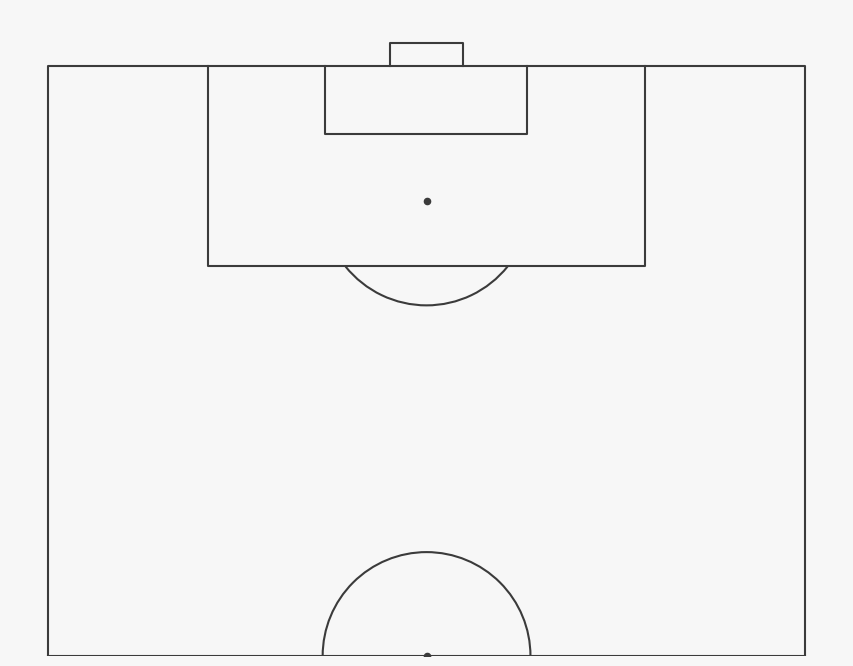

In [136]:
# Plotting Pitch

## Set background colour
background = '#F7F7F7'

## Create figure 
fig, ax = plt.subplots(figsize=(11, 7))
fig.set_facecolor(background)

## Draw the pitch
draw_pitch(orientation='vertical',    # 'horizontal'
           aspect='half',             # 'fll'
           pitch_color=background,
           line_color='#3B3B3B',
           ax=ax
          )

## Show figure
plt.tight_layout()
plt.show()

In [137]:
## Define function for plotting a DataFrame of shots
def create_pass_map(df,
                    pitch_length_x,
                    pitch_length_y,
                    orientation,
                    aspect,
                   ):

    """
    Function to create a pass map, utilising the 'draw_pitch' function, created by Peter McKeever @petermckeever.
    """

    ### Define fonts and colours
    title_font='Alegreya Sans'
    main_font='Open Sans'
    background='#F7F7F7'
    title_colour='black'
    text_colour='black'
    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.rcParams['xtick.color'] = text_colour
    mpl.rcParams['ytick.color'] = text_colour
    mpl.rcParams.update({'font.size': 18})

    ## Create figure 
    fig, ax = plt.subplots(figsize=(16.5, 10.5))
    fig.set_facecolor(background)
    #ax.patch.set_facecolor('w')

    ## Pitch dimensions - Opta
    pitch_length_x = 100
    pitch_length_y = 100

    """
    ## Set title
    ax.set_title('Title',
                 loc='left',
                 fontweight='bold',
                 fontsize=18,
                 #fontfamily='title_font'
                )
    """

    ## Set Gridlines 
    #ax.grid(lw=0.25, color='k', zorder=1)


    ## Draw the pitch using the 'draw_pitch' function
    draw_pitch(x_min=0,
               x_max=pitch_length_x,
               y_min=0,
               y_max=pitch_length_y,
               orientation=orientation,
               aspect=aspect,
               pitch_color=background,
               line_color='#3B3B3B',
               ax=ax
              )

    ## Define X and Y values
    y = df['x'].tolist()
    x = df['y'].tolist()
    endX = df['endX'].tolist()
    endY = df['endY'].tolist()
    
    ## Define Z order
    zo = 12

    ### Create scatter plot of shots
    ax.scatter(x,
               y,
               marker='o',
               color='red',
               edgecolors='black',
              #linewidths=0.5,
              #s=400,
               alpha=0.7,
               zorder=zo,
               label='Shots'
              )

    ## Set title
    ax.set_title(f'Opta Event Data of {count_passes:,} Passes',
                 loc='left',
                 color='#3B3B3B', 
                 fontweight='bold',
                 fontfamily=main_font,
                 fontsize=20,
                )


    ## Save figure
    #if not os.path.exists(fig_dir_opta + '/opta_shots_v_full_pitch_std.png'):
    #    plt.savefig(fig_dir_opta + '/opta_shots_v_full_pitch_std.png', bbox_inches='tight', dpi=300)
    #else:
    #    pass

    ## Show figure
    plt.tight_layout()
    plt.show()

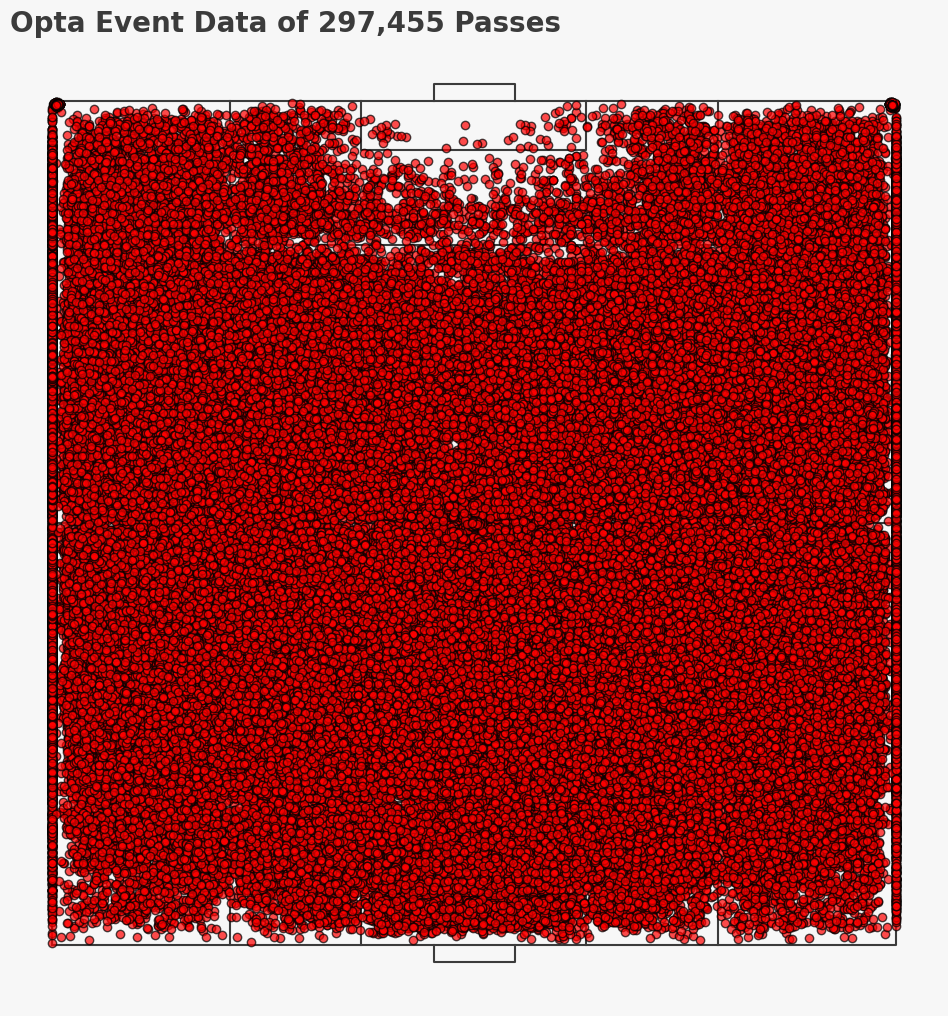

This visualisation shows the passes made in the dataset, including what appears to be quite a few outliers. These are addressed later in the Treating Outliers section (section 7).


In [138]:
create_pass_map(df=df_opta_passes_select,
                pitch_length_x=120,
                pitch_length_y=80,
                orientation='vertical',    # 'horizontal'
                aspect='fll'               #'half'
               )

print('This visualisation shows the passes made in the dataset, including what appears to be quite a few outliers. These are addressed later in the Treating Outliers section (section 7).')

# 4.5 Drop Duplicates

Removal of the duplicates ensures that if there's any errors with how the data is saved, if any files are read more than once, these duplicate entries will be removed from the data. As each event has a unique ID, no data within individual matches should be removed.

In [139]:
# Drop Duplicates
df_opta_passes_dedupe = df_opta_passes_select.drop_duplicates()

In [140]:
# Check - before and after deduplication
print('No. rows in Events DataFrame BEFORE deduplication: {}'.format(len(df_opta_passes_select)))
print('No. rows in DataFrame AFTER deduplication: {}\n'.format(len(df_opta_passes_dedupe)))
print('-'*60+'\n')
print('Variance in rows before and after deduplication: {}\n'.format(len(df_opta_passes_dedupe) - len(df_opta_passes_select)))

No. rows in Events DataFrame BEFORE deduplication: 297455
No. rows in DataFrame AFTER deduplication: 297455

------------------------------------------------------------

Variance in rows before and after deduplication: 0



# 4.6 Select Only Open Play (OP) Passes
### Can either create a model for set pieces or put all in one. If so, exclude this piece.

Select only passes for play type = isRegularPlay

Other play types are available, including: isDirectFreeKick, isSetPiece, isFromCorner, isAssisted, isThrowIn, and isPenalty. However, for the simplicity of the model, these are removed.

A more sohpisticated moded that can be created with more time available would consider all these play types. An example is Michael Caley's model, where he creates six models for:

- regular shots
- passes from a direct free kick
- passes from a cross
- passes not from a cross

In [141]:
# Filter goal not in regular play
#df_opta_shots_non_og_op = df_opta_shots_non_og[df_opta_shots_non_og['isRegularPlay'] == 1]

In [142]:
# Check - before and after deduplication
#print('No. rows in Shots DataFrame BEFORE filtering for Open Play goals: {}'.format(len(df_opta_shots_non_og)))
#print('No. rows in Shots DataFrame AFTER filtering for Open Play goals: {}\n'.format(len(df_opta_shots_non_og_op)))
#print('-'*60+'\n')
#print('Variance in rows BEFORE and AFTER filtration: {}\n'.format(len(df_opta_shots_non_og_op) - len(df_opta_shots_non_og)))

# 4.7 Feature Engineering
The Feature Engineering in this notebook is kept simple, just creating a few new basic features.

In [143]:
# Create 'isFoot' attribute
df_opta_passes_dedupe['isFoot'] = np.where(((df_opta_passes_dedupe['isLeftFoot'] == 1) | (df_opta_passes_dedupe['isRightFoot'] == 1)) &
                                              (df_opta_passes_dedupe['isHead'] == 0)
                                            , 1, 0
                                            )

The following code creates three, important features that are crucial to the Logistic Regression modeling and we will use to filter out improbable shots. These include:

- The distance of the shot from the goal (x-axis);
- The distance of the shot from the center of the pitch (y-axis); and
- The angle of the shot to the goal.

These can all be determined using Pythagoras' theorem and basic trigonometry. For more information, David Sumpter's lecture How to Build An Expected Goals Model 1: Data and Model for Friends of Tracking @ the 17 minute mark.

In [144]:
pass_start_x = df_opta_passes_dedupe.x
pass_start_y = df_opta_passes_dedupe.y
pass_end_x = df_opta_passes_dedupe.endX
pass_end_y = df_opta_passes_dedupe.endY

df_opta_passes_dedupe['distance_of_pass'] = np.sqrt(((pass_end_x - pass_start_x)**2) + ((pass_end_y - pass_start_y)**2) )

# 4.8 Treating Outliers

Outliers in an Expected Assists model can be described as two types of data points:

1. Data points that are wrong, i.e. passes that never happened; and
2. Data points that are correct, i.e. passes happened in reality, but you do not want the model to learn from.

The first point is easy to understand - a data for the shot is incorrectly collected. It therefore needs to be removed.

For the second point, an example could be the last minute of the game and the team that is currently losing has a corner. They therefore decide to take out the goalkeeper as an extra man to try and nick a goal. However, the corner isn't successful, the other team counter attacks and an assist occurs follwed by a shot from 50m into the empty goal. This shot took place, but we do not want the model to learn that there is a chance to score from this area as our current data doesn't account for the goalkeeper being out of their goal. If tracking data was available and we knew the goal was empty, maybe yes. If we don't have this data, however, it's best to exclude it.

The outliers treated in this model will just be for pass position. Other features are not considered at this stage due to time contraints. The following cells analyse with visualisation where shots take place and those that are scored.

### Create 2D Histograms for passes and assists used to generate Heat Maps

In [145]:
df_opta_passes_dedupe.head(1)

,id,x,y,endX,endY,isLeftFoot,isRightFoot,isHead,isOpenPlay,isThrowIn,isFreeKick,isCorner,isThroughBall,isAssist,isFoot,distance_of_pass
2,2.318209e+09,50.0,50.0,40.7,43.0,0,1,0,1,0,0,0,0,0,1,11.640017


In [146]:
# Two dimensional histogram
H_Pass = np.histogram2d(df_opta_passes_dedupe['x'], df_opta_passes_dedupe['y'], bins=50, range=[[0, pitch_length_x], [0, pitch_length_y]])
df_op_assists = df_opta_passes_dedupe[df_opta_passes_dedupe['isAssist'] == 1]
H_Assist = np.histogram2d(df_op_assists['x'], df_op_assists['y'], bins=50, range=[[0, pitch_length_x], [0, pitch_length_y]])

Create custom colour map

In [147]:
# Choose colormap
cmap=plt.cm.Reds

# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

# Create new colormap
my_cmap = ListedColormap(my_cmap)

visualize shots

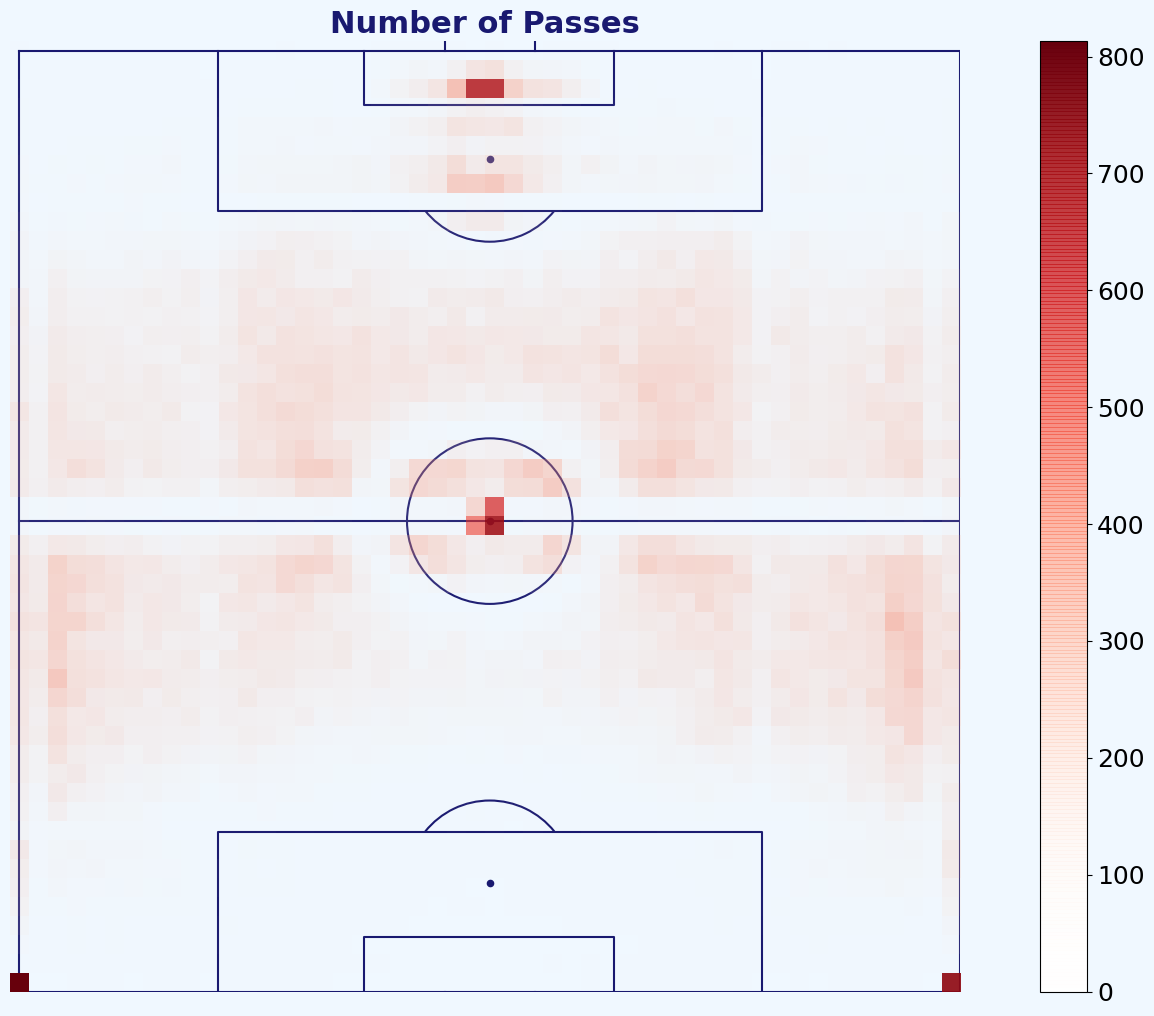

The visualisation looks as expected. Most of the passes where taken either in the midfield. Next we'll visualise where the assists occured.


In [148]:
# Visualise Shots

## Set background colour
background = 'aliceblue' #"white"

## Create figure 
fig, ax = plt.subplots(figsize=(16.5, 10.5))
fig.set_facecolor(background)

## Draw the pitch
draw_pitch(x_min=0,
           x_max=pitch_length_x,
           y_min=0,
           y_max=pitch_length_y,
           orientation='vertical', # "horizontal"
           aspect="fll",
           pitch_color=background,
           line_color="midnightblue",
           ax=ax
          )

## Heat map
pos=ax.imshow(H_Pass[0],
              extent=[-1, pitch_length_y, pitch_length_x, -1],
              aspect='auto',
              cmap=my_cmap
             )

## Colour bar
fig.colorbar(pos, ax=ax)

## Set title
ax.set_title('Number of Passes',
             loc='center',
             color='midnightblue', 
             fontweight='bold',
             fontfamily='DejaVu Sans',
             fontsize=22,
            )

## Save figure
#if not os.path.exists(fig_dir_opta + '/op_shots_v_full_shots.png'):
#    plt.savefig(fig_dir_opta + '/op_shots_v_full_shots.png', bbox_inches='tight', dpi=300)
#else:
#    pass

## Show figure
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

print("The visualisation looks as expected. Most of the passes where taken either in the midfield. Next we'll visualise where the assists occured.")

Visualize Assists

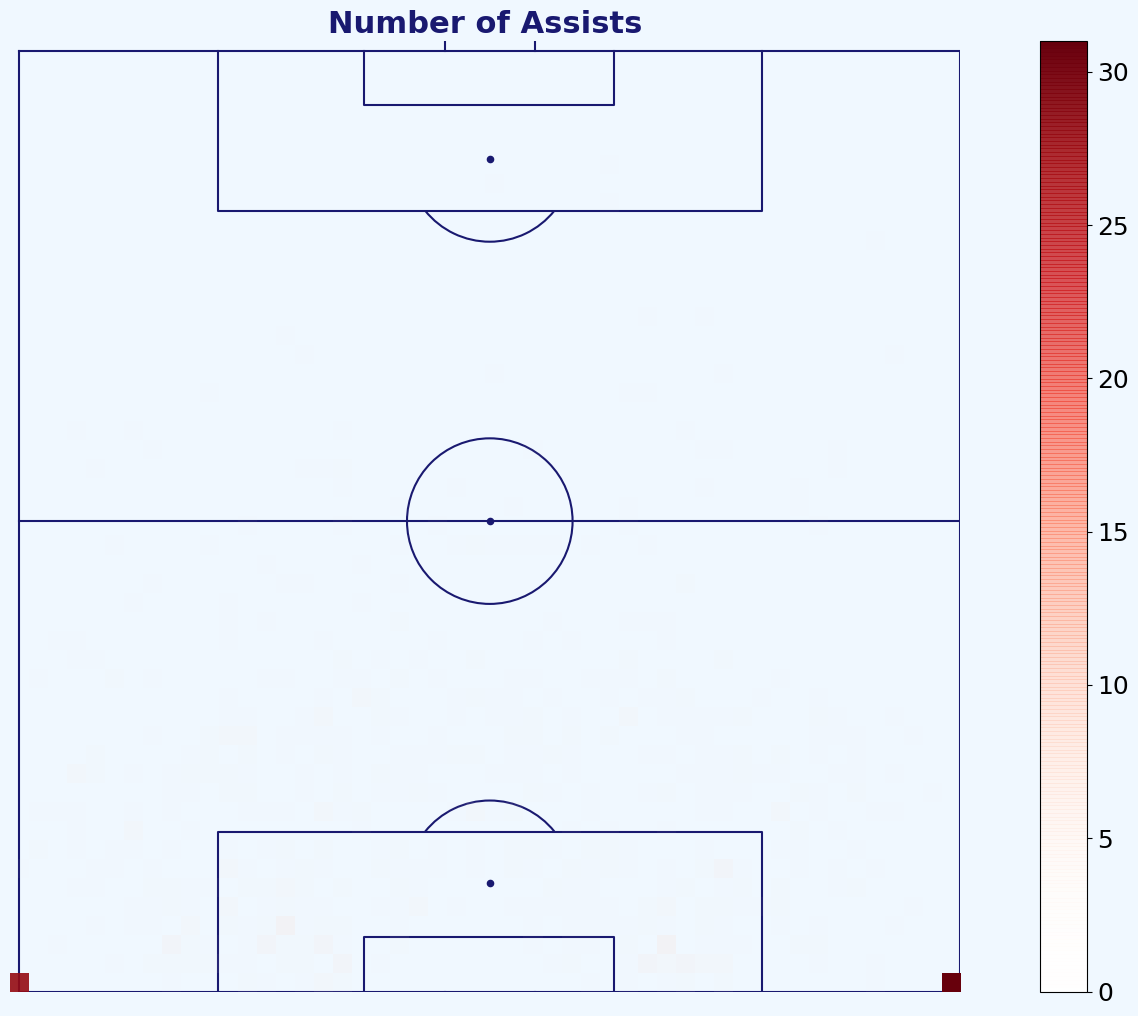

Again, the visualisation looks as expected. Most of the goals scored were within the 6 or 18-yard box. Again, there appears to be a slight bias to the goalkeeper's left, but it is generally even.
Next we'll investigate the probability from scoring per zone i.e. the number of goals divided by the number of shots.


In [149]:
# Visualise Goals

## Set background colour
background = 'aliceblue' #"white"

## Create figure 
fig, ax = plt.subplots(figsize=(16.5, 10.5))
fig.set_facecolor(background)

## Draw the pitch
draw_pitch(x_min=0,
              x_max=pitch_length_x,
              y_min=0,
              y_max=pitch_length_y,
              orientation="vertical", # "horizontal"
              aspect="fll",
              pitch_color=background,
              line_color="midnightblue",
              ax=ax
             )

## Heat map
pos=ax.imshow(H_Assist[0],
              extent=[-1, pitch_length_y, pitch_length_x, -1],
              aspect='auto',
              cmap=my_cmap
             )

## Colour bar
fig.colorbar(pos, ax=ax)

## Set title
ax.set_title('Number of Assists',
             loc='center',
             color='midnightblue', 
             fontweight='bold',
             fontfamily='DejaVu Sans',
             fontsize=22,
            )

## Save figure
#if not os.path.exists(fig_dir_opta + '/op_shots_v_full_goals.png'):
#    plt.savefig(fig_dir_opta + '/op_shots_v_full_goals.png', bbox_inches='tight', dpi=300)
#else:
#    pass

## Show figure
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

print("Again, the visualisation looks as expected. Most of the goals scored were within the 6 or 18-yard box. Again, there appears to be a slight bias to the goalkeeper's left, but it is generally even.")

print("Next we'll investigate the probability from scoring per zone i.e. the number of goals divided by the number of shots.")

#### Frequency of Assists 

Dividing number of assists by number of passes

C:\Users\Enrique\AppData\Local\Temp\ipykernel_14856\1598134683.py:23: RuntimeWarning: invalid value encountered in true_divide
  pos=ax.imshow(H_Assist[0]/H_Pass[0],


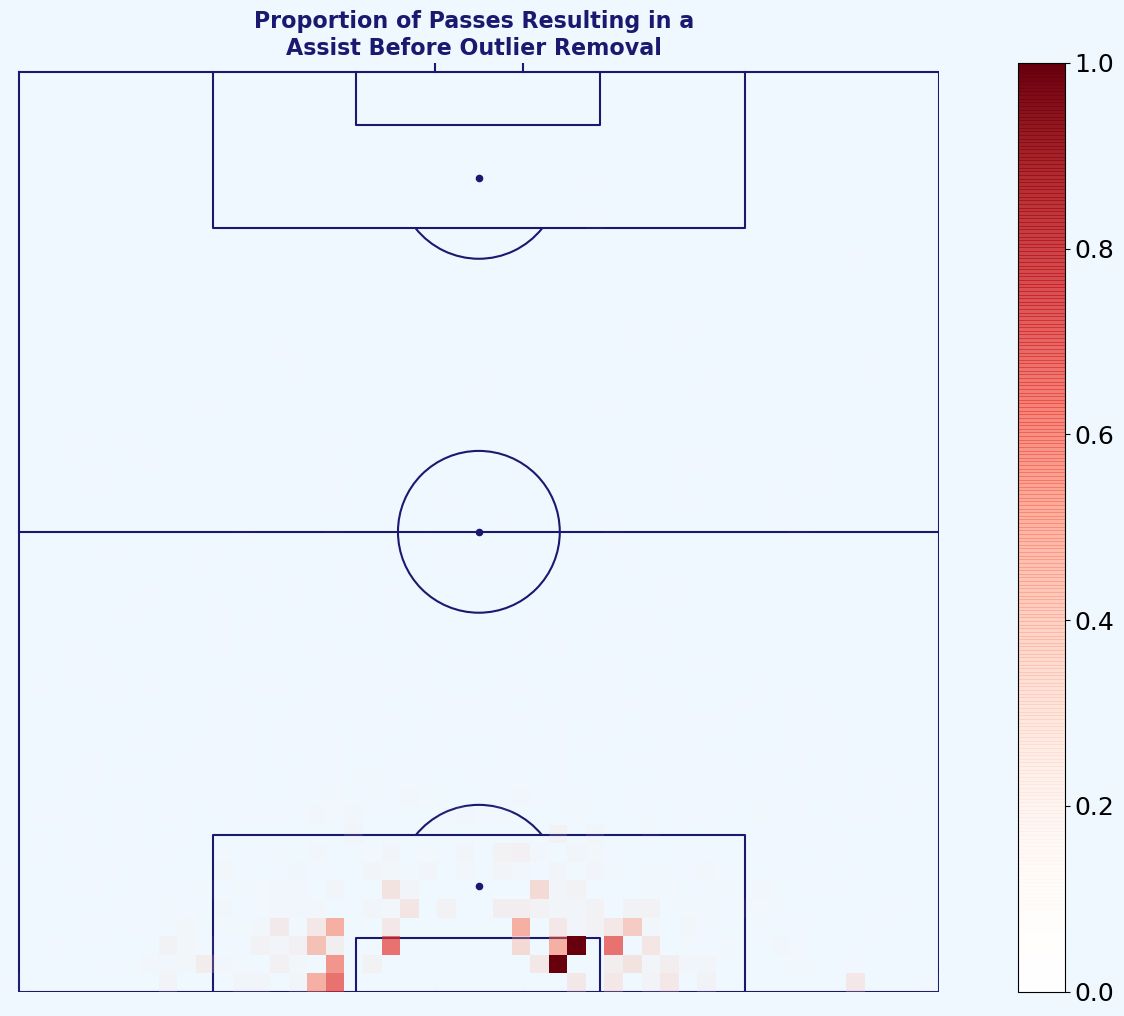

In [150]:
# Visualise the probability of scoring from different points

## Set background colour
background = 'aliceblue' #"white"

## Create figure 
fig, ax = plt.subplots(figsize=(16.5, 10.5))
fig.set_facecolor(background)

## Draw the pitch
draw_pitch(x_min=0,
              x_max=pitch_length_x,
              y_min=0,
              y_max=pitch_length_y,
              orientation="vertical", # "horizontal"
              aspect="fll",
              pitch_color=background,
              line_color="midnightblue",
              ax=ax
             )

## Heat map
pos=ax.imshow(H_Assist[0]/H_Pass[0],
              extent=[-1, pitch_length_y, pitch_length_x, -1],
              aspect='auto',
              cmap=my_cmap,
             #vmin=0,
             #vmax=0.5
             )

## Colour bar
fig.colorbar(pos, ax=ax)

## Set title
ax.set_title('Proportion of Passes Resulting in a\nAssist Before Outlier Removal',
             loc='center',
             color='midnightblue', 
             fontweight='bold',
             fontfamily='DejaVu Sans',
             fontsize=16,
            )


## Save figure
#if not os.path.exists(fig_dir_opta + '/op_shots_v_full_proportion_goals_from_shots_before_outlier_removal.png'):
#    plt.savefig(fig_dir_opta + '/op_shots_v_full_proportion_goals_from_shots_before_outlier_removal.png', bbox_inches='tight', dpi=300)
#else:
#    pass

## Show figure
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

There are data points far away from the goal that almost certainly wrong, the other might indeed have happened in a match and are therefore right, just like the Xabi Alonso goal against Luton where the goalkeeper was out of position, causing Xabi to shoot from a position that he otherwise would not shoot from. For example, it appears that a goal was scored from the edge of the of the attacking team's box. There is also a goal from the halfway line.

Reasons for this could be:

The data in correctly entered,
Coordinate system flipped for the particular shot (unlikely).
The data is required to be smooth so that the model doesn't think there's a 100% chance of scoring when shooting from the edge of the goalkeepers box.

There are three options to deal with these outliers:

Delete the outliers;
Use our experience and tell the model that the probability to score from this position is realistically 0. This means we change the target but leave the features as is; and
Assume that the shot happened closer to the goal, but we still assume that it went in. This means that we change the features but leave the target.
Due to time constraints, I'll be opting for the first strategy - changing the probability of goals scored from < 35m, and goals scored from > 18m and with an angle >45m, to have a probability of scoring equal to zero.

There are sophisticated ways to filter out these shots when a full set of Event data is available. For example, with full event data, we could determine the percentage likelihood of shooting from a position by looking at all actions on a pitch, and seeing how many times a player shoots relative to other actions. If the player 99 times out of 100 passes the ball instead of shooting for said position, we can set the chance that the player scorores to zero. With this logic, we can assume that all shots happening in any of the cells with < 1% shooting probability did not result in a goal.

In [151]:
############################################################################
############################################################################

The data now looks better. The goals from inside the attacking team's area and some acute goals scored outside the box at tight angles have been removed. Even though this was quite an arbitrary method of removing outliers, as this is not a complete dataset and a well known problem, I believe this is an adequate method in this circumstance.

The output now looks a lot like the general Expected Goals diagram that features in David Sumpter's (@Soccermatics) book Soccermatics, in which goals in the circle around the 6-yard box have roughly a 30% of scoring, 15% in the circle outside between the 6 and 12-yard box, and 7% towards the edge and just outside the box. This diagram also shows that the angle the shot has is important, which shots closer to the goal but from an acute angle having less chance of scoring than shots in with high visibility of the goal from the edge of the box.

Expected Goals diagram

For more information, see David Sumpter's talk: 'Expected Goals to a football player' below:

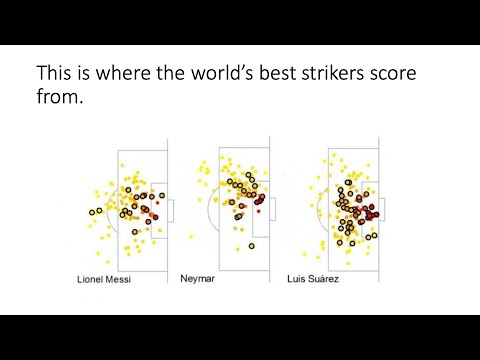

In [152]:
# How to explain Expected Goals to a football player by David Sumpter (@Soccermatics)
YouTubeVideo('Xc6IG9-Dt18')

# 4.9 Final Dataset

Create a copy of the finald dataset, ready for modeling.

In [153]:
df_passes_final = df_opta_passes_dedupe.copy()

In [154]:
df_passes_final.shape

(297455, 16)

# 5. Model Selection

The two considered models for the purpoase of creating the Expected Goals model are:

1. Logistic Regression; and
2. XGBoost (a type of Gradient Boosted Trees algorithm).

This notebook goes into detail of training a model using Logistic Regression. A further model is then created using XGBoost in a subsequent notebook [link]. This notebook and model was created after the initial submission of this CFG Junior Data Scientist task.

The reasons why these two algorithms were chosen and in the order that they have been selected is explained later in this section and made evident throughout the subsequent sections of this notebook.

The future scope of this Expected Goals model could include the use of alternative Gradient Boosting algorithms includeing lightGBM and CatBoost, however, on writing, only the Logistic Regression and XGBoost algorithms have been used, as achieving the absolute best performance is not the primary motvation of this exercise.

# 5.1. Classification Algorithms

- Logistic regression is a type of classification algorithm.
- In a classification task, the outputs of an algorithm fall into one of various pre-chosen categories. The classification model attempts to predict the output value when given several input variables, placing the example into the correct category.
- In contrast, for a regression task, the output variable is a numerical value that exists on a continuous scale, or to put that another way the output of a regression task is an integer or a floating point value.

# 5.2. Logistic Regression

- In statistics, the Logistic model (or logit model) is used to model the probability of a certain class or event existing such as pass/fail, win/lose, alive/dead or healthy/sick [link].
- Logistic regression is a statistical model that in its basic form, uses a logistic gunction to model a binrary dependent variable i.e. it is a classification algorithm, used when the value of the target variable is categorical in nature [link]
- Logistic regression is most commonly used when the data in question has binary output, so when it belongs to one class or another, or is either a 0 or 1.
- Unlike regression tasks, classification tasks have discrete categories.
- Although the algorithm is called 'Logistic Regression', it is, in fact, a classification algorithm. This is just something to be remembered

# 5.3. The Sigmoid Function

- A sigmoid function is a mathematical function having a characteristic 'S'-shaped curve or sigmoid curve when plotted on a graph [link].
- The Sigmoid function takes values between 0 and 1 and 'squishes' them towards the margins at the top and bottom, labeling them as 0 or 1.
- The equation of the Sigmoid function is:

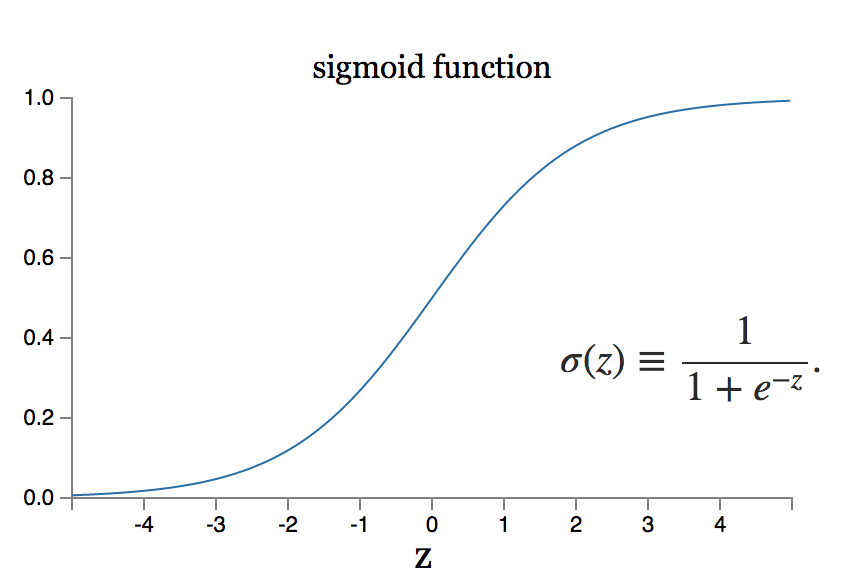

where e is Euler's number, representing the exponential function or exponential constant, and it has a value of approximately 2.71828.

This gives a value y that is extremely close to 0 if xis a large negative value and close to 1 if x is a large positive value. After the input value has been squeezed towards 0 or 1, the input can be run through a typical linear function, but the inputs can now be put into distinct categories.

# 5.4. Common Uses of Logistic Regression

- Logistic Regression should only be used when the target variables fall into discrete categories and that if there’s a range of continuous values the target value might be, Logistic Regression should not be used.
- Examples of situations you might use logistic regression in include:
1. Predicting if an email is spam or not spam;
2. Whether a tumor is malignant or benign;
3. Whether a mushroom is poisonous or edible; and
4. Predicting whether a shot results in a goal, or not.

- Although Logistic Regression is best suited for instances of binary classification, it can be applied to multiclass classification problems, classification tasks with three or more classes. You accomplish this by applying a'one vs. all' strategy. Let’s say you have three different classes that instances in your dataset could fall into, and if you had these three classes you could treat them as three different binary classification problems. In this instance, you would train a classifier on just the examples belonging to Class A vs. all the examples belonging to all other classes. You would then do the same thing for Class B, and finally for Class C. After the classifiers have learned to distinguish their chosen class from other classes, you just run the three classifiers on the inputs and whichever classifier is most confident it has chosen the correct class for that example, that is what class you put the example in. This is not required to be covered in this notebook.

# 5.5. XGBoost

- XGBoost stands for Extreme Gradient Boosting.
- It is a performant machine learning library based on the paper Greedy Function Approximation: A Gradient Boosting Machine by Friedman.
- It is an open source machine learning library providing a high-performance implementation of gradient boosted decision trees.
- It is originally written in C++ and is comparatively faster than other ensemble classifiers.
- It belongs to a family of boosting algorithms and uses the gradient boosting (GBM) framework at its core.
- XGBoost implements a Gradient Boosting algorithm based on decision trees.
- The XGBoost algorithm has been very often been the algorithm of choice since its inception in 2014, often the go to algorithm in winning Kaggle competition submissions.
- In this notebook, the full model pipeline is built using Logistic Regression. To find out more about Gradient Boosting algorithms and XGBoost, see the XGBoost notebook [link] or the following links for more in-depth discussion on XGBoost.
1. XGBoost Official Documentation
2. XGBoost Wiki

# 5.6. Reason for Selection of Logistic Regression in Submitted (Initial) Notebook

- Due to time constraints, only one Expected Goals model was created using one algorithm;
- Both Logistic Regression and XGBoost have their pros and cons, which were used to assess the reason for selection the model submitted. These can be summarised as follows:

#### Pros of Logistic Regression

- Very easy to implement. Easier to interpret than XGBoost - model can be interpreted to indicate feature importance;
- Fast training speed - faster than XGBoost;
- More stable model than XGBoost;
- Logistic Regression is less inclined to overfit than Decision Trees and Gradient Boosting algorithms;
- The model coefficients of Logistic Regression can be used to indicate the importance of the features; and
- A well-tuned Logistic Regression model can perform nearly as well as a model created using Decision Trees or Gradient Boosting algorithms such as XGBoost.

#### Cons of Logistic Regression

- Less accurate than XGBoost. Many Kaggle competitions are won using XGBoost, not Logistic Regression. However, XGBoost is not guaranteed to be better than Logistic Regression in every setting.

#### Pros of XGBoost

- It's also easy to implement use and gets a good performance with little tuning;
- Highly accurate: many Kaggle competitions are won using XGBoost;
- It uses the power of parallel processing;
- It is faster than Gradient Boosting;
- It is highly flexible;
- It supports regularisation;
- It is designed to handle missing data with its in-build features (sparse-aware). In the case of this notebook, all missing values are treated and this is not an advantage that is required;
- The user can run a cross-validation after each iteration; and
- It works well in small to medium dataset.

#### Cons of XGBoost

- More prone to over-fitting than Decision Trees and Gradient Boosting algorithms;
- Less explainable than Logistic Regression; and
- Takes some time to tune parameters.

For this task, having the best possible model performance was not the priority. The goal of this notebook is to have a functioning, interpretable model that can be applied for the two following tasks:

1. To assess a separate dataset from opta sample data; and
2. To create a model that can be interpreted an explain to both Data Scientists and Football Practitioners – creating a model with the smallest Log Loss is not the only requirement, the results need to be explained in English to non-technical individuals.

For this reason, this notebook works with Logistic Regression, and then a further model created using XGBoost is trained to both try and further improve performance and provide a comparison to the Logistic Regression model, to sense-check the work created in this notebook. This can be found at the following [link].

# 6. Modeling

First model created as a baseline for which interations of improvement are based

# 6.1. Feature Selection

The initial model just uses the features first included in the dataset. Future iterations include engineered and one-hot encoded categorical features.

The two that are of most interest to start are:

1. The position of the shot was taken on the pitch as position_xM and position_yM (converted in the Data Engineering section'; and
2. The body part the shot was taken with, i.e. left foot, right foot or head. This information is already encoded in BodyPartCode (converted from strings to codes in the Data Engineering section'.

In [155]:
# Features of the final shots DataFrame
df_passes_final.columns

Index(['id', 'x', 'y', 'endX', 'endY', 'isLeftFoot', 'isRightFoot', 'isHead',
       'isOpenPlay', 'isThrowIn', 'isFreeKick', 'isCorner', 'isThroughBall',
       'isAssist', 'isFoot', 'distance_of_pass'],
      dtype='object')

In [156]:
# Select Features of interest
features_cols = ['distance_of_pass',
                #'distance_to_centerM',    # commented out as elected to go with 'angle' instead
                 'isOpenPlay',
                 'isFoot',
                 'isHead',
                 'isFreeKick',
                 'isCorner',
                 'isThroughBall'
                ]

# Define Target
target_col = ['isAssist']

# Assign Feature and Target to separate DataFrames and Series
X = df_passes_final[features_cols]
y = df_passes_final[target_col]

In [157]:
# DataFrame of Features
X.head()

,distance_of_pass,isOpenPlay,isFoot,isHead,isFreeKick,isCorner,isThroughBall
2,11.640017,1,1,0,0,0,0
5,9.860020,1,0,1,0,0,0
6,30.997419,1,1,0,0,0,0
7,15.829403,1,1,0,0,0,0
8,35.114100,1,1,0,0,0,0


In [158]:
# Series of Labels
y.head()

,isAssist
2,0
5,0
6,0
7,0
8,0


# 6.2. Split the dataset into a train set and a test set

Split the data into a training set which will be used to build the model, and a testing set that is not used to build the model, but which we use to evaluate the model's predictions.

The Expected Goals model is trained on 70% of the data and the remaining 30% is evaluate the model.

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

# 6.3. Train Logistic Regression Model

In [161]:
reg_model = LogisticRegression(random_state=42, max_iter=200)
reg_model.fit(X_train, np.array(y_train).ravel())

LogisticRegression(max_iter=200, random_state=42)

# 6.4. Predict on the Test Set

In [162]:
pred_probs = reg_model.predict_proba(X_test)[:,1]
pred_vals = reg_model.predict(X_test)

# 6.5. Evaluation Metric Definition

This Expected Goals model is required to calculate the probability of a shot resulting in a goal (i.e. P[goal|shot,situation]) given a certain state e.g. position of the shot, left foot, number of defenders, etc. Therefore, the metric used needs to be appropriate for measuring the probability of a binary classifier.

The following sections define what a Loss Function is, the different type if classification problems, the metrics considered in the initial model, and a selection of the most suitable metrics along with the reasons as to why that is.


### 6.5.1. What is a Loss Function?

- The loss function tells how good your model is in predictions.
- When training a model, to optimise the model's performance, we are looking to reduce the error between the predicted values and the actual values i.e. reducing the loss.
- If the model predictions are closer to the actual values the loss will be the minimum and if the predictions are totally away from the original values the loss value will be the maximum.

### 6.5.2. Evaluation Metrics for Classification

Commonly used metrics for classification avilable in the [scikit-learn](https://scikit-learn.org/stable/index.html) package can be seen in the table below. For more information on [scikit-learn](https://scikit-learn.org/stable/index.html) evaluation metrics, see the following [[link](https://scikit-learn.org/stable/modules/model_evaluation.html)]:

The metrics considered in this model are:

- Accuracy;
- Log Loss; and
- ROC AUC (aka AUC).

Each of these metrics is discussed in detail as to their suitability and non-suitability.


### 6.5.3. Accuracy

Accuracy measures the share of right and wrong decisions and does not take into consideration at all the certainty of a decision, whether you are 51% sure or 99% sure. When having unbalanced data, i.e. on outcome happens way more often than the other, it is very simple to get a good accuracy. All you need to do is to just always predict the outcome that is more likely. For this reason, Accuracy is an inappropriate metric for this model.

In [163]:
# Compute Accuracy of initial model
print(f'Accuracy of model: {sk_metrics.accuracy_score(y_test, pred_vals)*100:.1f}%')

Accuracy of model: 99.8%


In [161]:
np.unique(pred_vals)

array([0, 1])

In [165]:
# Shot outcomes types and their frequency
df_passes_final.groupby(['isAssist']).isAssist.count()

isAssist
0    296785
1       670
Name: isAssist, dtype: int64

The current model predicts that all shots result in no goals. This results in a high accuracy, as the ratio of goals to no goals is 9,551 to 1,374 (14.39%). Despite this high accuracy, 'Accuracy' is not a good metric to evaluate model performance of a Logistic Regression model.

### 6.5.4. Log Loss

- Log Loss or Binary Cross Entropy is the most important classification metric based on probabilities and when predicting probabilities the metric you should always look at is the Log Loss [[link](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a)].
- The Log Loss compares each of the predicted probabilities to actual class output which can be either 0 or 1. It then calculates the score that penalises the probabilities based on the distance from the expected value. That means how close or far from the actual value. Formally defined, the Log Loss is the negative average of the log of corrected predicted probabilities. Mathematically, this is represented as:

Negative Average Formula

- The value of the negative average of corrected probabilities is the Log loss or Binary cross-entropy
- Instead of calculating corrected probabilities, we can calculate the Log loss using the formula given below.

Log Loss Formula
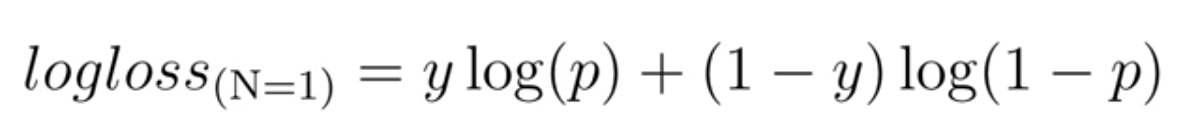

where pi is the probability of class 1, and (1-pi) is the probability of class 0.

- It's hard to interpret raw Log Loss values, but Log Loss is still a good metric for comparing models. For any given problem, a lower Log Loss value means better predictions.
- Log Loss is a slight twist on something called the Likelihood Function. In fact, Log Loss is -1 * the log of the likelihood function.
- The likelihood function answers the question "How likely did the model think the actually observed set of outcomes was."
- When the observation belongs to class 1 the first part of the formula becomes active and the second part vanishes and vice versa in the case observation’s actual class are 0. This is how we calculate the Binary cross-entropy.
- When creating predictions and multiplying each of the values together, with enough numbers, the result gets so small that computers can't keep track of it. So, as a clever computational trick is to instead keep track of the log of the Likelihood. This is in a range that's easy to keep track of. We multiply this by negative 1 to maintain a common convention that lower loss scores are better.

This model looks at the probability with which a goal is scored, or not scored and is therefore a binary classification problem. For this reason, Log Loss is the appropriate metric to assess this Expected Goals model and is the metric that this notebook will look to reduce when going through iterations of improvement.

The Log Loss for the initial model is the following:

In [166]:
# Compute the Log Loss of initial model
pred_probs = reg_model.predict_proba(X_test)[:,1]
print(f'Log Loss of model: {sk_metrics.log_loss(y_test, pred_probs):.5f}')

Log Loss of model: 0.01409


### 6.5.5. ROC AUC

The ROC AUC of a model is the probability that the model ranks a random positive example (i.e. a successful shot) more highly than a random negative example (i.e. unsuccessful shot).

The problem with measuring the ROC AUC of a Expected Goals model is that it only looks at ranking of the positive vs. the negative examples and not about the probabilities that are assigned to the examples. We, however, are interested in knowing the probability of a shot being successful. This is not captured by the ROC AUC.

In [167]:
# Compute the AUC of initial model
print(f'ROC AUC of our model: {sk_metrics.roc_auc_score(y_test, pred_probs)*100:.2f}%')

ROC AUC of our model: 69.47%


The ROC AUC of the initial model says that when randomly selecting a successful shot and an unsuccessful shot, there is a 69.47% chance that our model gives the successful shot a higher probability than the unsuccessful shot.

To prove that ROC AUC in not useful, this can be demonstrated by oversestimated the probabilities of the ball going in.

In [168]:
print(f'Currently predicted goals when ball is passed: {np.mean(pred_probs)*100:.2f}%')

# Overestimate the probabilities
pred_probs_over = pred_probs * 5
print(f'Overestimated predicted success when ball is passed: {np.mean(pred_probs_over)*100:.2f}%')

Currently predicted goals when ball is passed: 0.23%
Overestimated predicted success when ball is passed: 1.14%


Now we predict that 62% of all shots are successful. Something that is completely ridiculous. But guess what happens when we look at the two metrics log loss and AUC

In [169]:
print(f'Log loss w/o overestimation: {sk_metrics.log_loss(y_test, pred_probs):.3f}')
print(f'Log loss with overestimation: {sk_metrics.log_loss(y_test, pred_probs_over):.3f}')
print(f'AUC w/o overestimation: {sk_metrics.roc_auc_score(y_test, pred_probs)*100:.2f}%')
print(f'AUC with overestimation: {sk_metrics.roc_auc_score(y_test, pred_probs_over)*100:.2f}%')

Log loss w/o overestimation: 0.014
Log loss with overestimation: 0.024
AUC w/o overestimation: 69.47%
AUC with overestimation: 69.47%


We can see that the Log Loss skyrocketed as expected whilst the the AUC remained exactly the same. This is because the AUC only measures the ranking between the shots, but does not at all measure if the probabilities make any sense. AUC is therefore not a reliable metric when evaluation a Expected Goals model.

The AUC however can be useful to communicate results to non data scientists. In this analysis, we will focus oin reducing the Log Loss during model development, however, using the AUC, we can explain how good the model is with the answer "It has a 71% chance of detecting the successful shot from the unsuccessful one" rather than "It has a log loss of 0.345".

# 6.6 Model Evaluation

In [170]:
# Computer Log Loss of model
pred_probs = reg_model.predict_proba(X_test)[:,1]
print(f'Log Loss of model: {sk_metrics.log_loss(y_test, pred_probs):.5f}')

# Compute the AUC of model
print(f'AUC of our model: {sk_metrics.roc_auc_score(y_test, pred_probs)*100:.2f}%')

Log Loss of model: 0.01409
AUC of our model: 69.47%


In [171]:
# Logistic Model coefficients
for i, col in enumerate(X_train.columns):
    print(f"Coefficient of {col}: {reg_model.coef_[0][i]:.3f}")

Coefficient of distance_of_pass: 0.018
Coefficient of isOpenPlay: 1.169
Coefficient of isFoot: 0.298
Coefficient of isHead: 0.686
Coefficient of isFreeKick: -0.265
Coefficient of isCorner: 3.802
Coefficient of isThroughBall: 4.336


# 6.7. Save Final Model

Save final model to be exported and applied to the provided Opta Event data

In [172]:
# Save the model
pickle.dump(reg_model, open(os.path.join('Models\expected_assists_model_lr.sav'), 'wb'))

# 6.8. Save Final Dataset

Export the final dataset to be used for further analysis and modeling, including XGBoost algorithms.

In [173]:
# Export the final datasets, including the separate train and test sets
#df_train_exp.to_csv(os.path.join(data_dir_shots, 'engineered', 'train_shots_engineered.csv'), index=None, header=True)
#df_test_exp.to_csv(os.path.join(data_dir_shots, 'engineered', 'test_shots_engineered.csv'), index=None, header=True)
#df_complete.to_csv(os.path.join(data_dir_shots, 'engineered', 'complete_shots_engineered.csv'), index=None, header=True)

# 7. Feature Interpretation

Analysing the features is a very important step in the process of model development for at least two reasons:

1. It allows you to communicate why the model predicted what it predicted;
2. It is often a cause to trigger change in the actual doing (assume our model identifies that there is a very severe disadvantage when shooting with the weak foot; this might trigger to slightly adjust the training and add more elements of shooting with the weak foot); and
3. It helps you to sense-check the model results and identify potential bugs.

This section is again split into smaller parts in which we answer different questions

#### Does a variable have a positive or a negative effect on the likelihood to score?

This question is fortunately somehow simple to answer. All you need to do is to look at the signs of the coefficients of our final model. So let's print all of them quickly:

In [175]:
features = ['distance_of_pass',
            #'distance_to_centerM',    # commented out as elected to go with 'angle' instead
            'isOpenPlay',
            'isFoot',
            'isHead',
            'isFreeKick',
            'isCorner',
            'isThroughBall']

print("Coefficients")
print("############")
for i, coef in enumerate(reg_model.coef_[0]):
    print(f"{features[i]}: {coef:.3f}")

Coefficients
############
distance_of_pass: 0.018
isOpenPlay: 1.169
isFoot: 0.298
isHead: 0.686
isFreeKick: -0.265
isCorner: 3.802
isThroughBall: 4.336


Even though the magnitude of the number might be of some interest as well, let's for now only focus on the sign, i.e. is the coefficient positive or negative: A negative coefficient means that the bigger the value in the feature, the more unlikely the player becomes to score when shooting given that all other features stay the same. A positive coefficient, in contrast, says that the bigger the value in the feature, the more likely the player is to score.

Let's look at distance_of_pass: There we have a positive number, indicating that the bigger the distance of the pass, the more likely it is for a pass end in a goal. Makes sense, doesn't it? So does that mean that every pass taken from 15 meters has a higher probability than a pass that is 12 meters? No, it doesn't, that's what we mean with given all other features stay the same. What the negative coefficient says, is, that if I have two passes with the same features, but one from 15 meters and the other from 12 meters, then the one taken from 12 meters had a higher chance of becoming an assist. That is something you should always keep in mind.

We can now go through some of features and have a look at whether the sign of the coefficient does intuitively make sense:

- distance_of_passM: as expected, the further the pass is from the end location, the more likely the chance to score;
- openplay: as expected, the further we are from the center of the field the less likely the chance to score;
- Number_Intervening_Opponents: the greater the number of opponent, the less likely the chance to score. This is unexpected;
- Number_Intervening_Teammates: as expected, the greater the number of intervening teammates, the less likely the chance to score;
- isFoot: the use of the foot to shoot reduces the chance to score. This goes against intuition, but is not unexpected as this was observed in the Feature Engineering section;
- isHead: the use of the head to shoot increasesthe chance to score. This goes against intuition, but is not unexpected as this was observed in the Feature Engineering section;
- High (interference): as expected, when the interference on the player is High (multiple defenders in close proximity and interfering with the shot), the less likely the shooter is to score.
- Medium (interference): as expected, when the interference on the player is Medium (a single defender was in close proximity to the shot-taker), the less likely the shooter is to score.
- Low (interference): as expected, when the interference on the player is Low (no or minimal interference), the more likely the shooter is to score.
- header_distance_to_goalM: as expected, the further the shooter is from the goal, the less likely the chance to score. This is already noted in the distance_to_goalM features. Again, think of this variable as a multiplier in case of a header. While it is in general bad to be far from the goal, it is especially bad when taking a header.

From this analysis, we now understand all the features and whether they have a positive or negative effect on scoring.

#### What are the most important features?

Loosely speaking, you can get the importance of a feature by looking at the magnitude of the coefficient. So let's quickly print them again, but now focus on the (absolute) magnitude rather than the sign. Notice: This is only valid after we have done the scaling of the variables!

In [174]:
features = ['distance_to_goalM',
           #'distance_to_centerM',
            'angle',
            'Number_Intervening_Opponents',
            'Number_Intervening_Teammates',
            'isFoot',
           #'isHead',
            'High',
           #'Medium',
            'Low',
            'header_distance_to_goalM'
           ]

print('Coefficients')
print('-'*40)
for i, coef in enumerate(reg_model.coef_[0]):
    print(f'{features[i]}: {coef:.3f}')

Coefficients
----------------------------------------
distance_to_goalM: -0.199
angle: -0.008
Number_Intervening_Opponents: 1.089
Number_Intervening_Teammates: -0.010


The biggest (absolute) coefficient belongs to distance_to_goalM and header_distance_to_goalM, indicating that the distance to the goal line is the most important feature. This inituatively makes sense. The next one is Number_Intervening_Opponents, which again, we expect that if there is a lot of opponents between the shooter and the goal, this will have a big affect on the shot. Next is the high interference, when multiple defenders are in close proximity and interfering with the shot, the less likely the shooter is to score. The next is angle and distance_to_centerM' of the shot.

The take home messages from this analysis are:

1. Position on the field is extremely important when shooting;
2. The distance to the goal line is super important, and even more so when taking a header; and
3. The further you are from the center of the field, the more unlikely to score.

These take home messages are more important than presenting a list of coefficients to coaches and football. It's important to take what can be seen in the data and translate it into digestable language.